# I. Import neccessary libraries

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import json
import gzip
import time
import re, random, os
import string
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns
from langdetect import detect

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# II. Import Data
The dataset used in this experiment came from the Musical Instrument category in the Amazon Review dataset and was saved in a JSON file. It contains 231,392 observations with relevant details such as product information, images, review content, user ID, etc. Each entry is a review of a specific product. The data is extracted and stored in a DataFrame `df` along with its corresponding features.

In [2]:
def getDF(path):
    # Open the gzip file
    with gzip.open(path, 'rb') as f:
        # Load the JSON content from the file
        data = [json.loads(line) for line in f]

    # Convert the JSON content to a DataFrame
    return pd.DataFrame(data)

# File path
file_path = r"C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Dataset\Musical_Instruments_5.json.gz"

# Get the DataFrame
df = getDF(file_path)

In [3]:
print("Data shape:",df.shape)
df.head()

Data shape: (231392, 12)


overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True  10 30, 2016  A3FO5AKVTFRCRJ  0739079891   
1      5.0      True  06 30, 2016  A3UCGC1DHFMBCE  0739079891   
2      5.0      True   05 9, 2016  A2S9SLRYLPGYZB  0739079891   
3      4.0      True  04 10, 2016  A15RTJWPG8OKOE  0739079891   
4      1.0      True   02 6, 2016  A12ET1WO3OAVU7  0739079891   

      reviewerName                                         reviewText  \
0        francisco                            It's good for beginners   
1   Eb Jack Murray  I recommend this starter Ukulele kit.  I has e...   
2     Clara LaMarr  G'daughter received this for Christmas present...   
3          Eagle80  According to my order history, I bought this t...   
4  Amazon Customer  Please pay attention better than I did to the ...   

                                             summary  unixReviewTime vote  \
0                                         Five Stars      1477785600  NaN   
1                                         Five Stars      1467244800  NaN   
2               Learning new songs to play regularly      1462752000  NaN   
3  A bargain-bin good-enough ukulele that's held ...      1460246400  NaN   
4                              Poor Quality product.      1454716800  NaN   

  style image  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN

In [4]:
# Convert 'reviewTime' to a pandas datetime object
df['reviewDate'] = pd.to_datetime(df['reviewTime'])
df.head()

overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True  10 30, 2016  A3FO5AKVTFRCRJ  0739079891   
1      5.0      True  06 30, 2016  A3UCGC1DHFMBCE  0739079891   
2      5.0      True   05 9, 2016  A2S9SLRYLPGYZB  0739079891   
3      4.0      True  04 10, 2016  A15RTJWPG8OKOE  0739079891   
4      1.0      True   02 6, 2016  A12ET1WO3OAVU7  0739079891   

      reviewerName                                         reviewText  \
0        francisco                            It's good for beginners   
1   Eb Jack Murray  I recommend this starter Ukulele kit.  I has e...   
2     Clara LaMarr  G'daughter received this for Christmas present...   
3          Eagle80  According to my order history, I bought this t...   
4  Amazon Customer  Please pay attention better than I did to the ...   

                                             summary  unixReviewTime vote  \
0                                         Five Stars      1477785600  NaN   
1                                         Five Stars      1467244800  NaN   
2               Learning new songs to play regularly      1462752000  NaN   
3  A bargain-bin good-enough ukulele that's held ...      1460246400  NaN   
4                              Poor Quality product.      1454716800  NaN   

  style image reviewDate  
0   NaN   NaN 2016-10-30  
1   NaN   NaN 2016-06-30  
2   NaN   NaN 2016-05-09  
3   NaN   NaN 2016-04-10  
4   NaN   NaN 2016-02-06

# III. Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231392 entries, 0 to 231391
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         231392 non-null  float64       
 1   verified        231392 non-null  bool          
 2   reviewTime      231392 non-null  object        
 3   reviewerID      231392 non-null  object        
 4   asin            231392 non-null  object        
 5   reviewerName    231367 non-null  object        
 6   reviewText      231344 non-null  object        
 7   summary         231341 non-null  object        
 8   unixReviewTime  231392 non-null  int64         
 9   vote            34777 non-null   object        
 10  style           121310 non-null  object        
 11  image           3889 non-null    object        
 12  reviewDate      231392 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 21.4+ MB


In [6]:
#check if there is any missing values
df.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          25
reviewText            48
summary               51
unixReviewTime         0
vote              196615
style             110082
image             227503
reviewDate             0
dtype: int64

Missing values (NaN) are found in several columns: reviewerName, reviewText, summary, vote, style, and images. To be precise, there are 25 missing values in reviewerName, 48 in reviewText, 51 in summary, 196,615 in vote, 110,082 in style, and 227,503 in image. Out of these numbers, only the missing values (empty string) in the reviewText column will severely impact the process of building a topic model. Besides, 48 out of 231,392 reviews is a relatively small percentage, therefore, these 48 reviews with missing text will be excluded from the dataset before building BERTopic model.

In [7]:
# Count number of users and products
unique_user_count = df['reviewerID'].nunique()
unique_verified_users_count = df[df['verified'] == True]['reviewerID'].nunique()
unique_unverified_users_count = df[df['verified'] == False]['reviewerID'].nunique()
unique_product_count = df['asin'].nunique()

# Display the counts
print(f"Number of total users: {unique_user_count}")
print(f"Number of verified users: {unique_verified_users_count}")
print(f"Number of unverified users: {unique_unverified_users_count}")
print(f"Number of products: {unique_product_count}")

Number of total users: 27530
Number of verified users: 27222
Number of unverified users: 9075
Number of products: 10620


There are 9,075 unverified users. As text bot and fake reviews are quite the issue in customer reviews, it is also advisable to remove these reviews to reduce the noise in the dataset.

In [8]:
# Function to detect different language in the review content
def detect_language(text):
    try:
        return detect (text)
    except:
        return 'Error'

In [ ]:
df['language'] = df['reviewText'].apply(detect_language)
print(f'Display number of reviews in each language:')
print(df['language'].value_counts())

Display number of reviews in each language:
en       214002
af         2989
ro         2450
ca         1943
so         1678
de          925
fr          662
es          548
no          508
pl          488
sl          470
sk          459
cy          437
da          420
pt          386
it          351
hu          324
et          315
tl          307
nl          229
sv          218
vi          191
cs          178
id          148
hr          145
fi          138
sq          133
Error       132
tr          101
sw           71
lv           34
lt           12
Name: language, dtype: int64


This dataset contains customer reviews written in different languages, indicating a broad international user base. While the predominant language is English with 214,022 reviews, 30 other identified languages make significant contributions to this dataset, such as Afrikaans (2,973 reviews), Romanian (2,458 reviews), and Catalan (1,943 reviews), Somali (1,695 reviews), German (931 reviews), and French (669 reviews). Besides, the 'Error' category with 132 entries suggests potential issues in language detection or data collection that might need attention. This linguistic diversity suggests the necessity for incorporating multilingual analysis during the model development phase.

Maximum Word Count: 4069
Minimum Word Count: 1
Average Word Count: 56.72814531185175


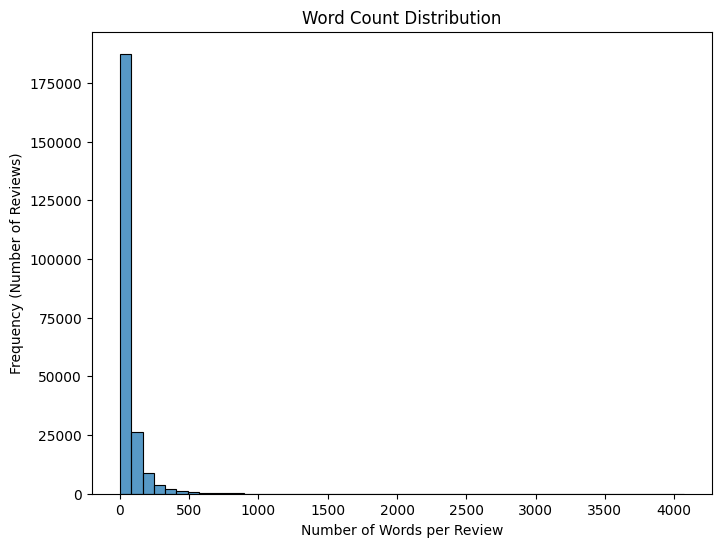

In [9]:
# Calculate max, min, and average word count
word_counts = df['reviewText'].apply(lambda x: len(str(x).split()))
max_word_count = word_counts.max()
min_word_count = word_counts.min()
avg_word_count = word_counts.mean()

# Display the calculated values
print(f"Maximum Word Count: {max_word_count}")
print(f"Minimum Word Count: {min_word_count}")
print(f"Average Word Count: {avg_word_count}")

# Plot the word count distribution
plt.figure(figsize=(8, 6))
sns.histplot(word_counts, bins=50)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency (Number of Reviews)")
plt.show()

This dataset has a mixture of both long text and short text with an average review length of 57 words. while the longest review consists of 4,069 words whilst the shortest review has none to one word. The word count distribution clearly shows that most of them are short text with less than 200 words.

In [10]:
# Calculate the distribution of product ratings
distribution = df['overall'].value_counts()
distribution

overall
5.0    161837
4.0     38783
3.0     16030
1.0      7465
2.0      7277
Name: count, dtype: int64

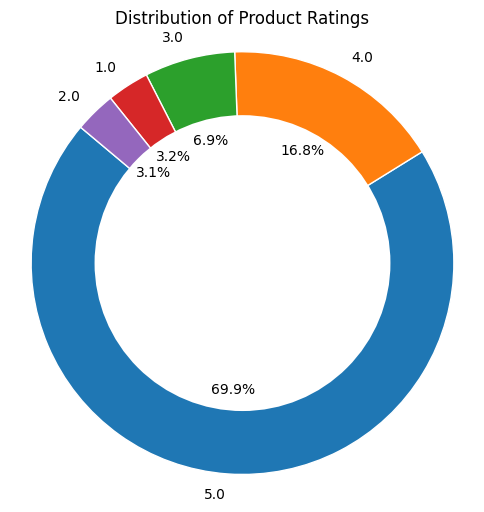

In [11]:
# Create a pie chart for the distribution of product ratings
plt.figure(figsize=(6, 6))
plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})
plt.title('Distribution of Product Ratings')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Add a white circle in the center for the donut effect
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The product rating ranges from 1.0 being the lowest to 5.0 being the highest. Looking at the product rating this donut chart, most of them have 5.0 and 4.0, accounting for 86.7 % of the overall reviews whereas 1.0 and 2.0 ratings only make up for a little more than 6% of all reviews. This indicates that the customers are quite satisfied with their purchase in general. This information will become useful later when doing a more in-depth analysis of which features or areas need improvement or continuing development after the topic modeling is complete.

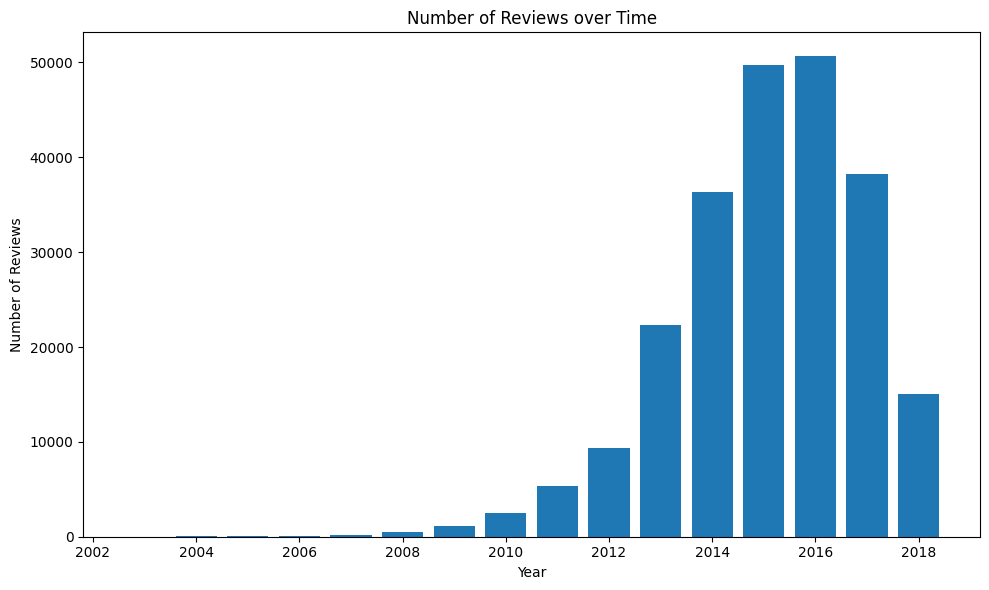

In [12]:
# Extract the year from the 'ReviewDate' column without adding it to the DataFrame
years = df['reviewDate'].dt.year

# Count the number of reviews in each year
review_counts = years.value_counts().reset_index()
review_counts.columns = ['year', 'review_count']

# Sort the DataFrame by year
review_counts = review_counts.sort_values('year')

# Plot the number of reviews by year
plt.figure(figsize=(10, 6))
plt.bar(review_counts['year'], review_counts['review_count'])
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews over Time')
plt.tight_layout()
plt.show()

In [13]:
# Extract unique years
unique_years = df['reviewDate'].dt.year.unique()

# Create a dictionary to store the months for each year
year_month_dict = {}

# Iterate through unique years and store the unique months for each year
for year in unique_years:
    months_in_year = df[df['reviewDate'].dt.year == year]['reviewDate'].dt.month.unique()
    year_month_dict[year] = sorted(months_in_year)  # Sort the months in ascending order

# Sort the years with missing months in ascending order
years_with_missing_months = sorted([year for year in year_month_dict.keys() if len(year_month_dict[year]) != 12])

# Print the sorted months missing in each year
for year in years_with_missing_months:
    missing_months = [month for month in range(1, 13) if month not in year_month_dict[year]]
    print(f"Year {year} is missing the following months: {missing_months}")

Year 2003 is missing the following months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
Year 2004 is missing the following months: [1, 2, 4, 5]
Year 2005 is missing the following months: [5, 7]
Year 2018 is missing the following months: [10, 11, 12]


The reviews were collected from October 2003 to September 2018 with most of them occurring between 2013 and 2017. There is missing data from the early years 2003, 2004, 2005, and later year 2018. More specifically, the missing data is in November 2003, December 2003, January 2004, February 2004, April 2004, May 2004, May 2005, and July 2005. Normally, in other analytical models, these missing values would be removed or replaced with appropriate values before the model development phase. However, in the case of topic modeling, the main factor that affects the outcome of a topic model is the textual data. Because the missing dates do not affect the development of a topic model, there is no need to eliminate or substitute them. However, it is essential to keep this in mind to come back and further look into this issue once the topics are defined.

# III. Data Pre-processing

The preprocessing pipeline is mentioned below:

1.  Remove reviews that have missing text
2.  Remove duplicate reviews
3.  Remove reviews from unverified users.

## 1. Check and remove reviews with missing text
There are 48 entries with missing review text in the reviewText column. They will severely impact the process of building a topic model. As 48 out of 231,392 reviews is a relatively small percentage, they will be excluded from the dataset before building LDA model. The original dataset is reduced to 231,344 entries.

In [14]:
# Identifying rows where 'reviewText' is missing
missing_review_text_rows = df[df['reviewText'].isna()]

# Displaying the number of rows with missing 'reviewText'
num_missing_reviews = missing_review_text_rows.shape[0]
print(f"Number of reviews with missing text: {num_missing_reviews}")

# Optionally, to display the rows with missing 'reviewText'
if num_missing_reviews > 0:
    print("Reviews with missing text:")
    display(missing_review_text_rows.head())

Number of reviews with missing text: 48
Reviews with missing text:


overall  verified   reviewTime      reviewerID        asin  \
16840      5.0      True  01 25, 2018  A3N0SYVG1A2T5Y  B0002E1NNC   
16999      5.0      True  11 18, 2017  A2ACJCJOSZOW8Z  B0002E1NNC   
17465      5.0      True  01 25, 2018  A3N0SYVG1A2T5Y  B0002E1NWI   
17627      5.0      True  11 18, 2017  A2ACJCJOSZOW8Z  B0002E1NWI   
25914      5.0      True  02 29, 2016  A2TB3K1Z2YG1O4  B0002E3CK4   

      reviewerName reviewText             summary  unixReviewTime vote  \
16840    Robert h.        NaN          Five Stars      1516838400  NaN   
16999      Private        NaN  Excellent Strings!      1510963200  NaN   
17465    Robert h.        NaN          Five Stars      1516838400  NaN   
17627      Private        NaN  Excellent Strings!      1510963200  NaN   
25914        Kelly        NaN          Five Stars      1456704000  NaN   

                                                   style image reviewDate  
16840  {'Size:': ' HD Light (.013-.053)', 'Style:': '...   NaN 2018-01-25  
16999  {'Size:': ' Light (.012-.053)', 'Style:': ' 80...   NaN 2017-11-18  
17465                                                NaN   NaN 2018-01-25  
17627                                                NaN   NaN 2017-11-18  
25914  {'Size:': ' Regular Light, 10-46', 'Style:': '...   NaN 2016-02-29

In [15]:
# Removing rows where 'reviewText' is missing
df = df.dropna(subset=['reviewText'])

# Optionally, to check the new size of the DataFrame after rows are removed
print(f"DataFrame size after removing rows with missing 'reviewText': {df.shape}")

DataFrame size after removing rows with missing 'reviewText': (231344, 13)


## 2. Check and remove duplicated reviews for the same product from the same customer
Subsequently, an additional 18,571 duplicates are discarded since they do not have any significant information for the topic modeling process. This step substantially reduces the amount of reviews in the dataset to 221,955 entries.

In [16]:
# Identify rows with duplicated 'reviewerID','asin',and 'reviewText'
duplicated_review_text = df[df.duplicated(subset=['reviewerID','asin','reviewText'], keep=False)]

# Sort the DataFrame by 'reviewText' to group duplicates together
sorted_duplicated_reviews = duplicated_review_text.sort_values(by='reviewText')

# Displaythe number of rows with duplicated 'reviewText'
num_duplicated_reviews = sorted_duplicated_reviews.shape[0]
print(f"Number of rows with duplicated 'reviewText': {num_duplicated_reviews}")

# Display the sorted duplicated review text rows
if num_duplicated_reviews > 0:
    print("Sorted Duplicated 'reviewText' Rows:")
    display(sorted_duplicated_reviews.head())  # Displaying first 50 for brevity

Number of rows with duplicated 'reviewText': 18571
Sorted Duplicated 'reviewText' Rows:


overall  verified   reviewTime      reviewerID        asin  \
80075      5.0      True   06 7, 2014  A29YV7R4QB2V64  B000VO1EA0   
88841      5.0      True   06 7, 2014  A29YV7R4QB2V64  B000VO1EA0   
85146      5.0      True  02 13, 2015  A38Q3KGB8PB0UI  B00135HFK4   
93912      5.0      True  02 13, 2015  A38Q3KGB8PB0UI  B00135HFK4   
84544      1.0      True  02 25, 2012  A333OWA198OUIA  B0011FORIE   

         reviewerName                                         reviewText  \
80075          Hunter  !!!!UPDATE!!!!\nSince people like to try to be...   
88841          Hunter  !!!!UPDATE!!!!\nSince people like to try to be...   
85146      Randy Fine                                                 #1   
93912      Randy Fine                                                 #1   
84544  Burkhard Kefes  (Very poor quality. You can not really tune it...   

                                           summary  unixReviewTime vote  \
80075  I love it!!! Jimmy Page Dazed and Confused!      1402099200    3   
88841  I love it!!! Jimmy Page Dazed and Confused!      1402099200    3   
85146                                   Five Stars      1423785600  NaN   
93912                                   Five Stars      1423785600  NaN   
84544                                 not tuneable      1330128000  NaN   

                           style  \
80075  {'Style:': ' Brazilwood'}   
88841  {'Style:': ' Brazilwood'}   
85146       {'Size:': ' SINGLE'}   
93912       {'Size:': ' SINGLE'}   
84544                        NaN   

                                                   image reviewDate  
80075  [https://images-na.ssl-images-amazon.com/image... 2014-06-07  
88841  [https://images-na.ssl-images-amazon.com/image... 2014-06-07  
85146                                                NaN 2015-02-13  
93912                                                NaN 2015-02-13  
84544                                                NaN 2012-02-25

In [17]:
# Remove duplicate rows based on selected columns
# keep='first' keeps the first occurrence and removes subsequent duplicates
df = df.drop_duplicates(subset=['reviewerID','asin','reviewText'], keep='first')

# Print the new size of the DataFrame after duplicates are removed
print(f"DataFrame size after removing duplicated reviews: {df.shape}")

DataFrame size after removing duplicated reviews: (221955, 13)


## 3. Check and remove reviews from unverified users
The next cleaning measure involves excluding the reviews from unverified users due to their potential to compromise the model's reliability by introducing inauthentic reviews from unverified sources, which may be generated by automated bots. From the dataset, a total of 23,015 reviews from 9,075 unverified users were removed. The remaining dataset has 198,940 reviews in total.

In [18]:
# check how many reviews are from verified users
df.value_counts('verified')

verified
True     198940
False     23015
Name: count, dtype: int64

In [19]:
# Removing unverified entries
df = df[df['verified'] == True]

# Print the new size of the DataFrame after removing reviews from unverified users
print(f"DataFrame size after removing removing reviews from unverified users: {df.shape}")

DataFrame size after removing removing reviews from unverified users: (198940, 13)


In [20]:
# Reset the DataFrame's index after data cleansing
df = df.reset_index(drop=True)

# IV. Building BERTopic model

After the data cleaning process, the dataset comprises of 198,940 cleaned reviews is used to build and refine the BERTopic model. To evaluate the relationships and distances between topics, BERTopic offers the visualize_topic function that generates an intertopic distance map. This feature is quite similar to the PyLDAvis tool used in LDA with Gensim where the distance between the bubbles reflects their similarities as closer topics are more similar. The experiment progresses through three stages of model configuration, each aimed at optimizing the thematic representation and interpretability of the resulting topics.

The initial phase of model configuration is building a BERTopic model with the default setting. This results in the extraction of 2,145 topics including outliers (topic -1) that do not fit into any category. The configuration at this stage has several problems, therefore, needs further model refinement.

The second phase of model configuration is refining the BERTopic model by adjusting parameters to enable multilingual support and automatic merger of topics by setting `language = multilingual` and `nr_topics = auto`. This results in a substantial reduction of topics from 2,145 to 1,371. The topic representative terms are becoming more specific. Despite this progress, challenges remain. Therefore, more model refinement is still needed.

The final stage of model configuration is fine-tuning various hyperparameters of the BERTopic model to further improve the results.

In [21]:
docs = df['reviewText']
docs

0                                   It's good for beginners
1         I recommend this starter Ukulele kit.  I has e...
2         G'daughter received this for Christmas present...
3         According to my order history, I bought this t...
4         Please pay attention better than I did to the ...
                                ...                        
198935                                   It's pretty great.
198936    Good inexpensive wiring harness. It will do th...
198937             Easily installed and worked as expected.
198938    The description stated they were full size pot...
198939    They are dime size not "full size" pots but it...
Name: reviewText, Length: 198940, dtype: object

## 1. Pre-calculate Embeddings

Further refining BERTopic model using just a few changes to the default BERTopic parameters. A breakdown of modifications at each step of BERTopic is as follows:

- **Embedding Model**: the ‘paraphrase-multilingual-MiniLM-L12-v2,’ which is a pre-trained embedding model supporting over 50 languages, is selected for Sentence Transformers. It is a great model for mutiple languages that balances performance with speed.

In [22]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/6217 [00:00<?, ?it/s]

- **Dimensionality Reduction**: For UMAP, `n_neighbors = 15` is set to help create larger and more coherent topic clusters and `random_state = 42` is set to make sure that the model gives the same results with each run.


In [23]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

- **Clustering**: With HDBSCAN, the `min_cluster_size` is set to 150 instead of the default value 10. This helps reducing the number of clusters by increasing their size and relevance.


In [24]:
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom')

- **Tokenizer**: With CountVectorizer, `stop_words = english` is set to ignore English stopwords and `min_df = 2` is set to eliminate words that occurs less than twice in the reviews. Besides, the `ngram_range = (1,2)` is set to include words that made up of one or two words. For example, ‘New York’ will be considered as one word instead of two words ‘New’ and ‘York.’


In [25]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

- **Topic Representation**: The default labels for each topic concatenates the top 10 words of each topic with underscores. This is not the best way to describe each topic. To improve the clarity and relevance of topic labels, various topic representations such as KeyBERTInspired, PartOfSpeech, and MaximalMarginalRelevance are used and compare together.


In [26]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

## 2. Training BERTopic Model

In [27]:
# Start the timer
start_time = time.time()

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  language='multilingual',
  top_n_words=10,
  nr_topics = "auto",
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

# End the timer
end_time = time.time()

2024-02-17 03:23:11,966 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-17 03:32:25,015 - BERTopic - Dimensionality - Completed ✓
2024-02-17 03:32:25,024 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-17 03:32:49,305 - BERTopic - Cluster - Completed ✓
2024-02-17 03:32:49,305 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-17 03:34:34,480 - BERTopic - Representation - Completed ✓
2024-02-17 03:34:34,489 - BERTopic - Topic reduction - Reducing number of topics
2024-02-17 03:35:47,789 - BERTopic - Topic reduction - Reduced number of topics from 139 to 77


In [28]:
# Calculate the duration in seconds
duration_seconds = end_time - start_time

# Convert the duration to hours, minutes, and seconds
hours = int(duration_seconds // 3600)
minutes = int((duration_seconds % 3600) // 60)
seconds = int(duration_seconds % 60)

print('Successfully build a BERTopic model! \n')
print("Execution time: ",hours,"hour(s) ",minutes," minute(s)",seconds," second(s)")

Successfully build a BERTopic model! 

Execution time:  0 hour(s)  12  minute(s) 38  second(s)


## 3. Custom Labels

After training, the number of topics is reduced to 77, including outliers, with more defined topic labels. Each topic is represented by different label representations as detailed below.

In [29]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  83475                       -1_strings_guitar_great_good   
1       0  55221                           0_guitar_sound_mic_great   
2       1   8625                         1_pedal_pedals_board_delay   
3       2   8146                  2_cable_cables_quality_connectors   
4       3   3194                3_price_great price_good price_good   
..    ...    ...                                                ...   
72     71    174                   71_images_video_class_ssl images   
73     72    173  72_perfectly_works perfectly_perfectly works_p...   
74     73    161                              73_sm58_shure_sm57_58   
75     74    158              74_link_nbsp_normal href_linked class   
76     75    153         75_love love_love_great strings_love great   

                                       Representation  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, mic, great, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images, video, class, ssl images, images na, ...   
73  [perfectly, works perfectly, perfectly works, ...   
74  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
75  [link, nbsp, normal href, linked class, cm_cr_...   
76  [love love, love, great strings, love great, s...   

                                              KeyBERT  \
0   [great, excellent, perfect, works great, good,...   
1   [instrument, acoustic, fender, guitars, amp, b...   
2   [great pedal, pedal great, pedals, pedalboard,...   
3   [good cable, nice cable, cable good, great cab...   
4   [price good, good price, price nice, nice pric...   
..                                                ...   
72  [id video, com images, images amazon, type hid...   
73  [works perfectly, perfectly works, worked perf...   
74  [shure sm58, shure sm57, shure sm7b, sm58 work...   
75  [ref cm_cr_arp_d_rvw_txt, cm_cr_arp_d_rvw_txt ...   
76  [love, love love, great love, love great, love...   

                                                  MMR  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, mic, great, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images, video, class, ssl images, images na, ...   
73  [perfectly, works perfectly, perfectly works, ...   
74  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
75  [link, nbsp, normal href, linked class, cm_cr_...   
76  [love love, love, great strings, love great, s...   

                                                  POS  \
0   [strings, guitar, great, good, sound, use, pro...   
1   [guitar, sound, mic, great, good, strings, str...   
2   [pedal, pedals, board, delay, power, distortio...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images, video, div, spacing, block, mini vide...   
73  [works, perfect, bad cut, past year, past, son...   
74  [shure, sm7b, perfect, great, price, used shur...   
75  [link, data, normal, guitar, stage, electric, ...   
76  [love, strings, great, spot, great pair, set, ...   

                                  Representative_Docs  
0        [Great., GREAT, These are my go to strings.]  
1   [I am really enjoying this guitar! Feels solid...  
2   [COMPARISONS: I have compared, side by side, t...  
3   [Good quality cable., Good quality cable., Ver...  
4   [Works well for great price. Bill, Very well-m...  
..                                                ...  
72  [<div id="video

To get all representations for a single topic, simply run the following:

In [30]:
topic_model.get_topic(1, full=True)

{'Main': [('pedal', 0.047955040933679006),
  ('pedals', 0.025851538484596953),
  ('board', 0.01253447147772729),
  ('delay', 0.010617262212797846),
  ('pedal board', 0.008941700685414318),
  ('power', 0.008343419907817085),
  ('distortion', 0.008214008572709831),
  ('tone', 0.007825419825938444),
  ('like', 0.007725137979037219),
  ('sounds', 0.007720355253786806)],
 'KeyBERT': [('great pedal', 0.88878906),
  ('pedal great', 0.85241246),
  ('pedals', 0.8163717),
  ('pedalboard', 0.8106307),
  ('pedal board', 0.80215955),
  ('pedal', 0.78920156),
  ('pedal does', 0.7417933),
  ('knob', 0.35366678),
  ('knobs', 0.34759733),
  ('looper', 0.328437)],
 'MMR': [('pedal', 0.047955040933679006),
  ('pedals', 0.025851538484596953),
  ('board', 0.01253447147772729),
  ('delay', 0.010617262212797846),
  ('pedal board', 0.008941700685414318),
  ('power', 0.008343419907817085),
  ('distortion', 0.008214008572709831),
  ('tone', 0.007825419825938444),
  ('like', 0.007725137979037219),
  ('sounds', 0

Among these, KeyBERTInspired gives the most relevant keywords that best represents the topic’s essence, therefore, will be chosen to be the method for cutomizing topic names.

Another important question arises: How many key terms are needed to accurately represent a topic? An examination of the most commonly used words within the top ten topics (as illustrated below) revealed that while a list of ten words provide a comprehensive view, most topic could be described using just the top two or three words.

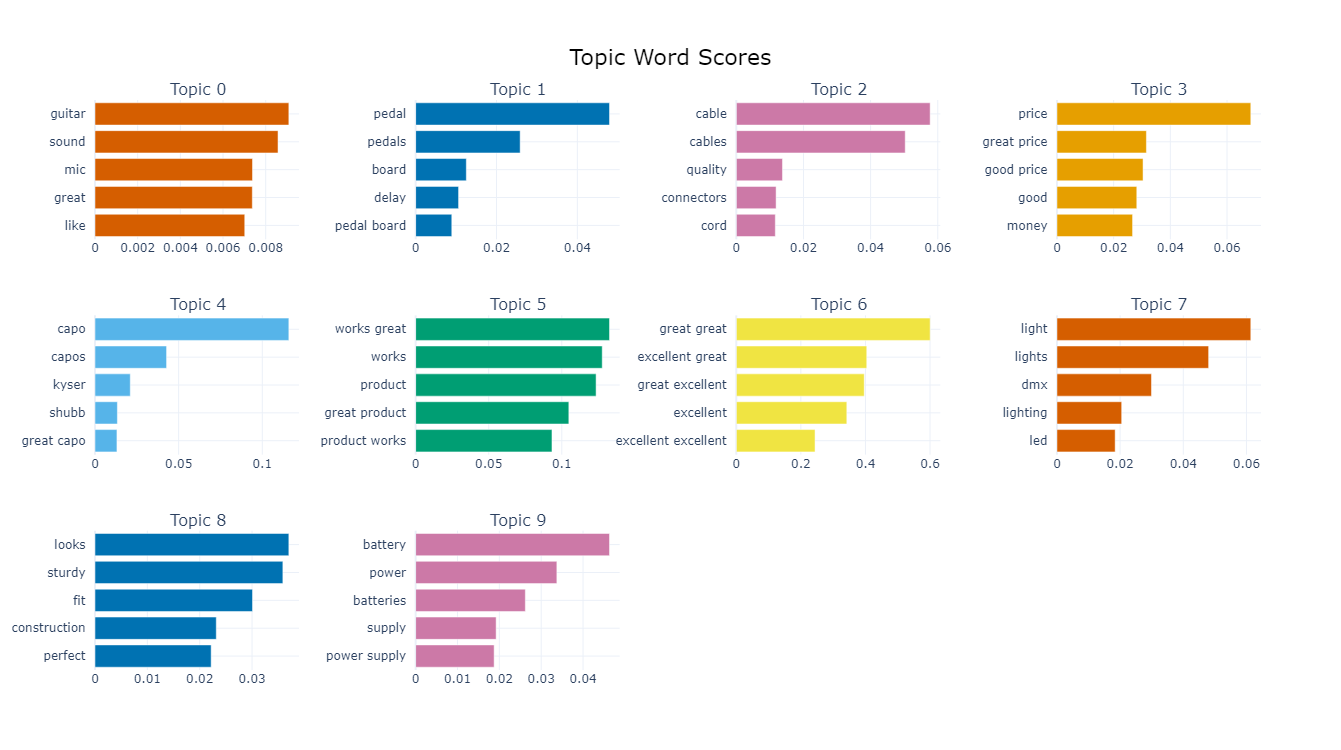

In [31]:
topic_model.visualize_barchart(top_n_topics=10)

To assess the importance of each word within a topic label, the term score is graphed.

Similar to the 'elbow method' used in k-means clustering to find the optimal number of clusters, the significance of each additional word decreases as more terms are included in the topic representation. From the figure below, it is clear that the top 2 words from each topic generally suffices to convey the main idea. While some topics might require up to 5 or 7 words to fully capture what the topic is all about, adding more words beyond that does not make any big difference in most cases.

This understanding leads to the generation of new custom labeling using `KeyBertInspired` with the top 2 words for each topic. This new custom label is shown in the column `CustomName` in the dataset. These new labels can be used across various BERTopic functions. These updated labels will show in the visualizations by setting `custom_labels = True`.

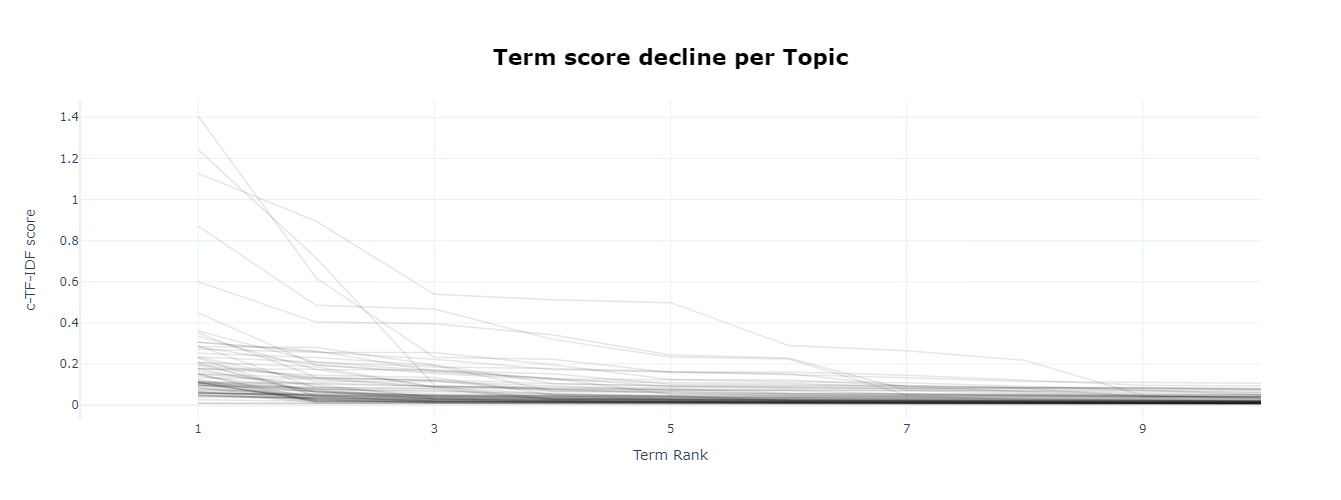

In [32]:
topic_model.visualize_term_rank()

In [33]:
# use KeyBERT as the topic representation with 2 words
keybert_topic_labels = {topic: f"Topic {topic}: {' | '.join(list(zip(*values))[0][:2])}" for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
topic_model.set_topic_labels(keybert_topic_labels)

In [34]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  83475                       -1_strings_guitar_great_good   
1       0  55221                           0_guitar_sound_mic_great   
2       1   8625                         1_pedal_pedals_board_delay   
3       2   8146                  2_cable_cables_quality_connectors   
4       3   3194                3_price_great price_good price_good   
..    ...    ...                                                ...   
72     71    174                   71_images_video_class_ssl images   
73     72    173  72_perfectly_works perfectly_perfectly works_p...   
74     73    161                              73_sm58_shure_sm57_58   
75     74    158              74_link_nbsp_normal href_linked class   
76     75    153         75_love love_love_great strings_love great   

                                           CustomName  \
0                         Topic -1: great | excellent   
1                      Topic 0: instrument | acoustic   
2                  Topic 1: great pedal | pedal great   
3                    Topic 2: good cable | nice cable   
4                    Topic 3: price good | good price   
..                                                ...   
72                    Topic 71: id video | com images   
73        Topic 72: works perfectly | perfectly works   
74                  Topic 73: shure sm58 | shure sm57   
75  Topic 74: ref cm_cr_arp_d_rvw_txt | cm_cr_arp_...   
76                         Topic 75: love | love love   

                                       Representation  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, mic, great, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images, video, class, ssl images, images na, ...   
73  [perfectly, works perfectly, perfectly works, ...   
74  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
75  [link, nbsp, normal href, linked class, cm_cr_...   
76  [love love, love, great strings, love great, s...   

                                              KeyBERT  \
0   [great, excellent, perfect, works great, good,...   
1   [instrument, acoustic, fender, guitars, amp, b...   
2   [great pedal, pedal great, pedals, pedalboard,...   
3   [good cable, nice cable, cable good, great cab...   
4   [price good, good price, price nice, nice pric...   
..                                                ...   
72  [id video, com images, images amazon, type hid...   
73  [works perfectly, perfectly works, worked perf...   
74  [shure sm58, shure sm57, shure sm7b, sm58 work...   
75  [ref cm_cr_arp_d_rvw_txt, cm_cr_arp_d_rvw_txt ...   
76  [love, love love, great love, love great, love...   

                                                  MMR  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, mic, great, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images, video, class, ssl images, images na, ...   
73  [perfectly, works perfectly, perfectly works, ...   
74  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
75  [link, nbsp, normal href, linked class, cm_cr_...   
76  [love love, love, great strings, love great, s...   

                                                  POS  \
0   [strings, guitar, great, good, sound, use, pro...   
1   [guitar, sound, mic, great, good, strings, str...   
2   [pedal, pedals, board, delay, power, distortio...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [images,

## 4. Visualization

#### 4.1.1 Intertopic Distance Map
To explore the relationships and distances between topics, BERTopic offers the `visualize_topic()` function. This feature is quite similar to the PyLDAvis tool used with Gensim. The distance between the bubbles reflects their similarities: closer topics are more similar. This gives a visual sense of how topics relate to one another.

An advantage of using this function is the interactive slider. This slider allows you to easily navigate through all topics or focus on a specific topic. For each selected topic, you can view key details such as the main keywords, the number of reviews it encompasses, and its neighboring topics.

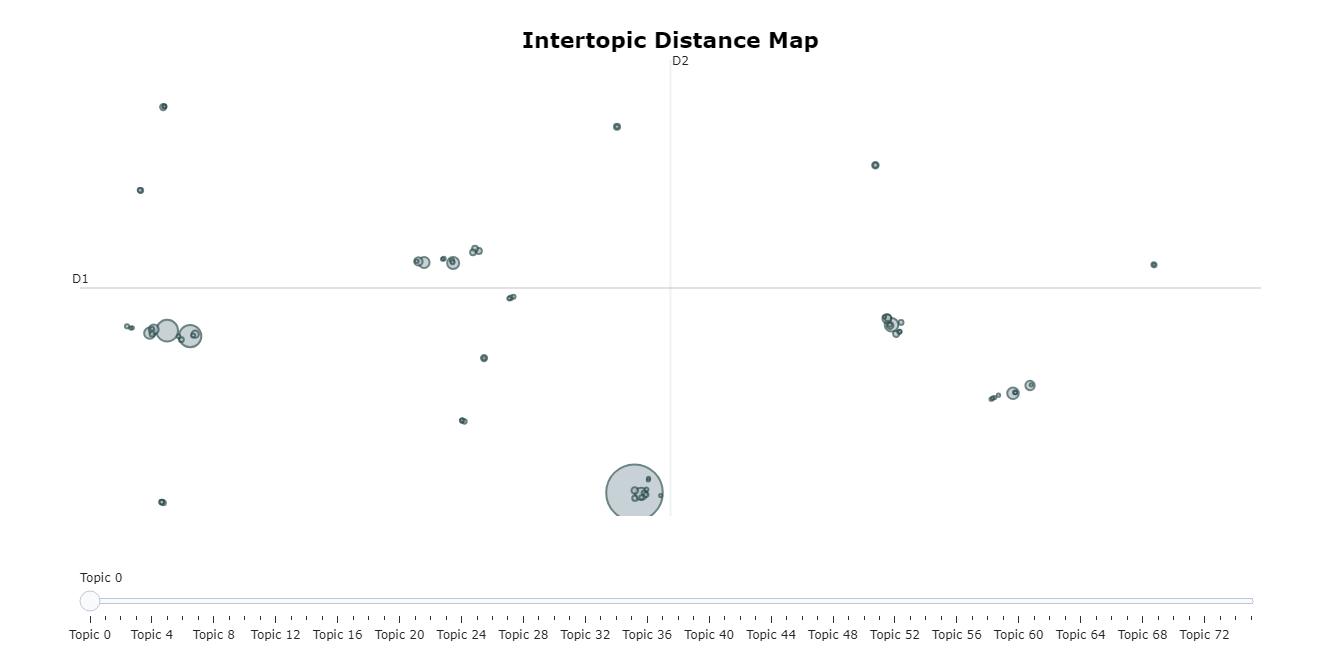

In [35]:
topic_model.visualize_topics(custom_labels=True)

As observed from the intertopic distance map, the model succeeded in forming several distinct topic clusters. However, the presence of some overlapping sections among the bubbles suggests that some topics could potentially be merged further.

To further determining which topics to merge involved a thorough examination of topic hierarchies and similarities. A hierarchy tree visually shows the relationships between topics. This tree used color coding to group similar topics, showing potential sub-topics nestled within larger topics. Hovering over the black nodes within the tree provided a representation of the topic at that level of the hierarchy.

#### 4.1.2 Hierarchy Visualization

100%|██████████| 75/75 [00:02<00:00, 29.58it/s]


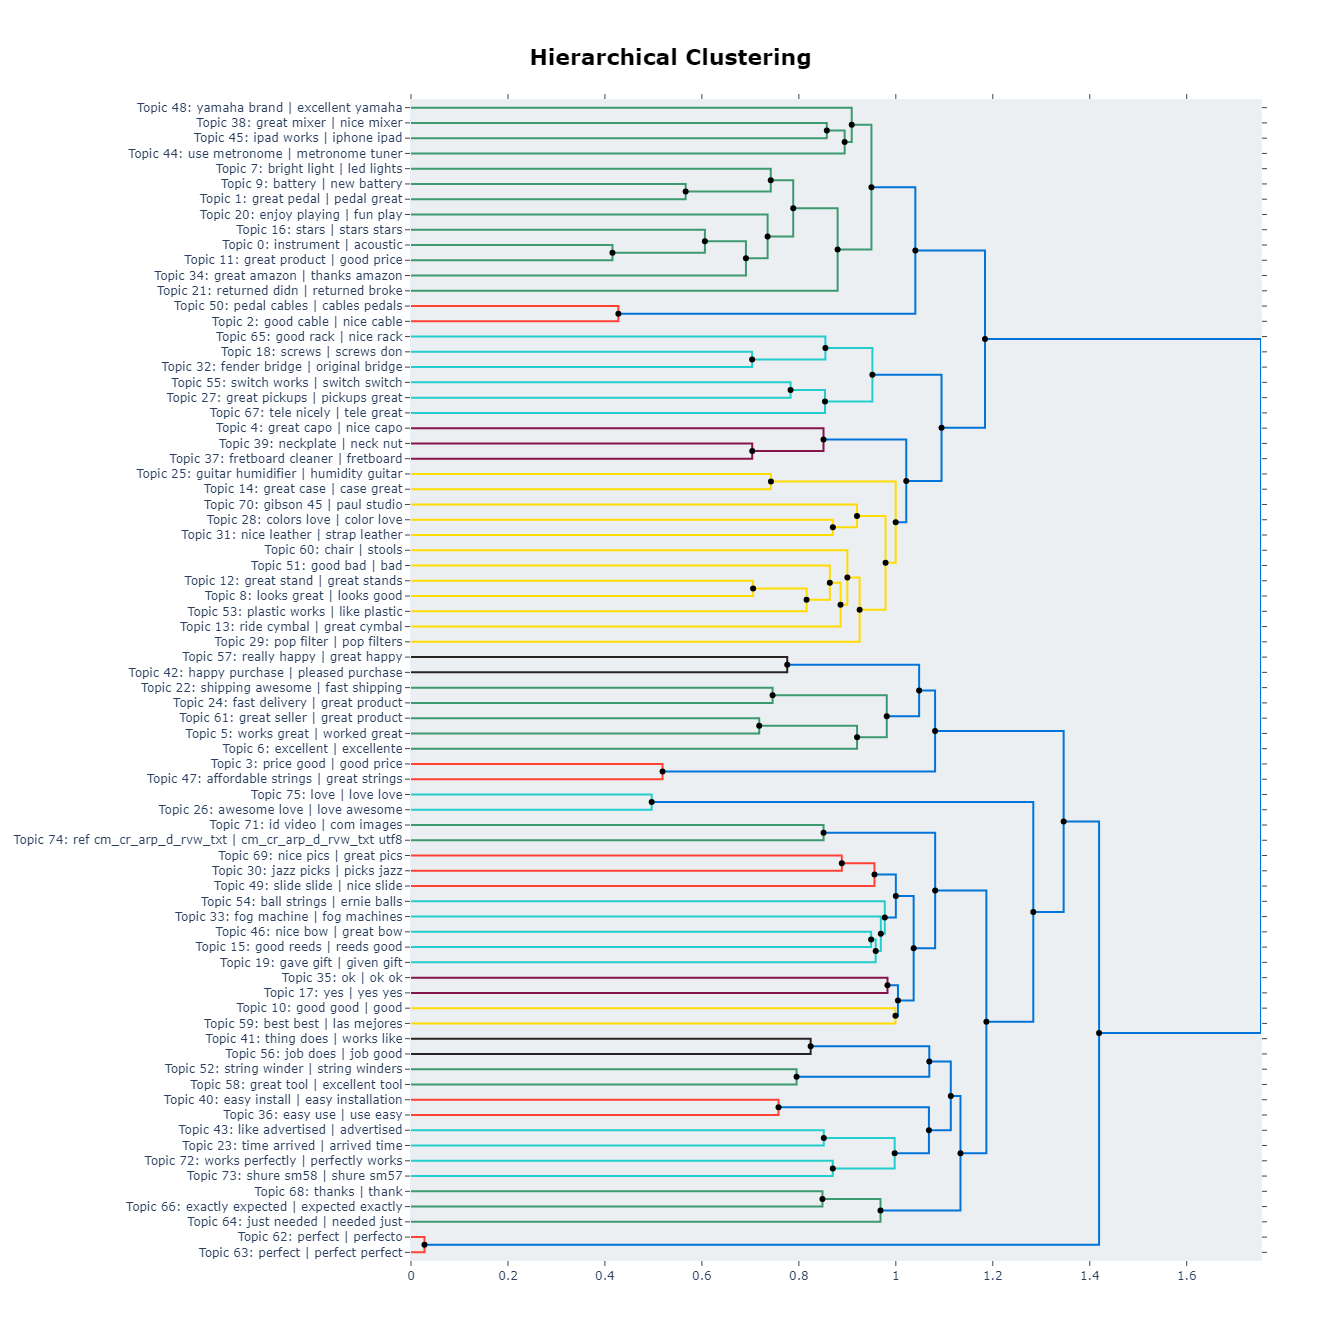

In [36]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True, width=1500, height=1000)

In [38]:
fig1 = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True, width=1500, height=1000)
fig1.write_html(r'C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Saved Models\BERTopic\hierarchy.html')

If you hover over the black circles, you will see the topic representation at that level of the hierarchy. These representations help you understand the effect of merging certain topics. Some might be logical to merge whilst others might not. Moreover, we can now see which sub-topics can be found within certain larger themes.

Although this gives a nice overview of the potential hierarchy, hovering over all black circles can be tiresome. Instead, we can use `topic_model.get_topic_tree` to create a text-based representation of this hierarchy. Although the general structure is more difficult to view, we can see better which topics could be logically merged.

In [39]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─great_pedal_sound_guitar_like
│    ├─pedal_sound_great_guitar_like
│    │    ├─pedal_sound_guitar_great_like
│    │    │    ├─metronome_mixer_ipad_yamaha_use
│    │    │    │    ├─■──yamaha_yamaha product_fits yamaha_mouthpiece_product ── Topic: 48
│    │    │    │    └─metronome_mixer_ipad_use_tuner
│    │    │    │         ├─mixer_ipad_use_mixers_iphone
│    │    │    │         │    ├─■──mixer_mixers_mackie_behringer_mix ── Topic: 38
│    │    │    │         │    └─■──ipad_iphone_app_stand_use ── Topic: 45
│    │    │    │         └─■──metronome_tuner_beat_metronomes_tempo ── Topic: 44
│    │    │    └─pedal_sound_guitar_great_like
│    │    │         ├─pedal_sound_guitar_great_like
│    │    │         │    ├─pedal_pedals_power_board_light
│    │    │         │    │    ├─■──light_lights_dmx_lighting_led ── Topic: 7
│    │    │         │    │    └─pedal_pedals_power_board_delay
│    │    │         │    │         ├─■──battery_power_batteries_supply_power supply ── Topic: 9
│    │  

#### 4.1.3 Heatmap
In addition to the visual assessment, a quantitative analysis to examine the similarity scores between pairs of closely related topics is presented in the heatmap below.

The heatmap's blocky appearance indicates the presence of topic clusters that share similarities. By zooming into these areas, we gain insights into the reasons behind their similarity. Hovering over the blocks reveals each topic's ID and its representation.

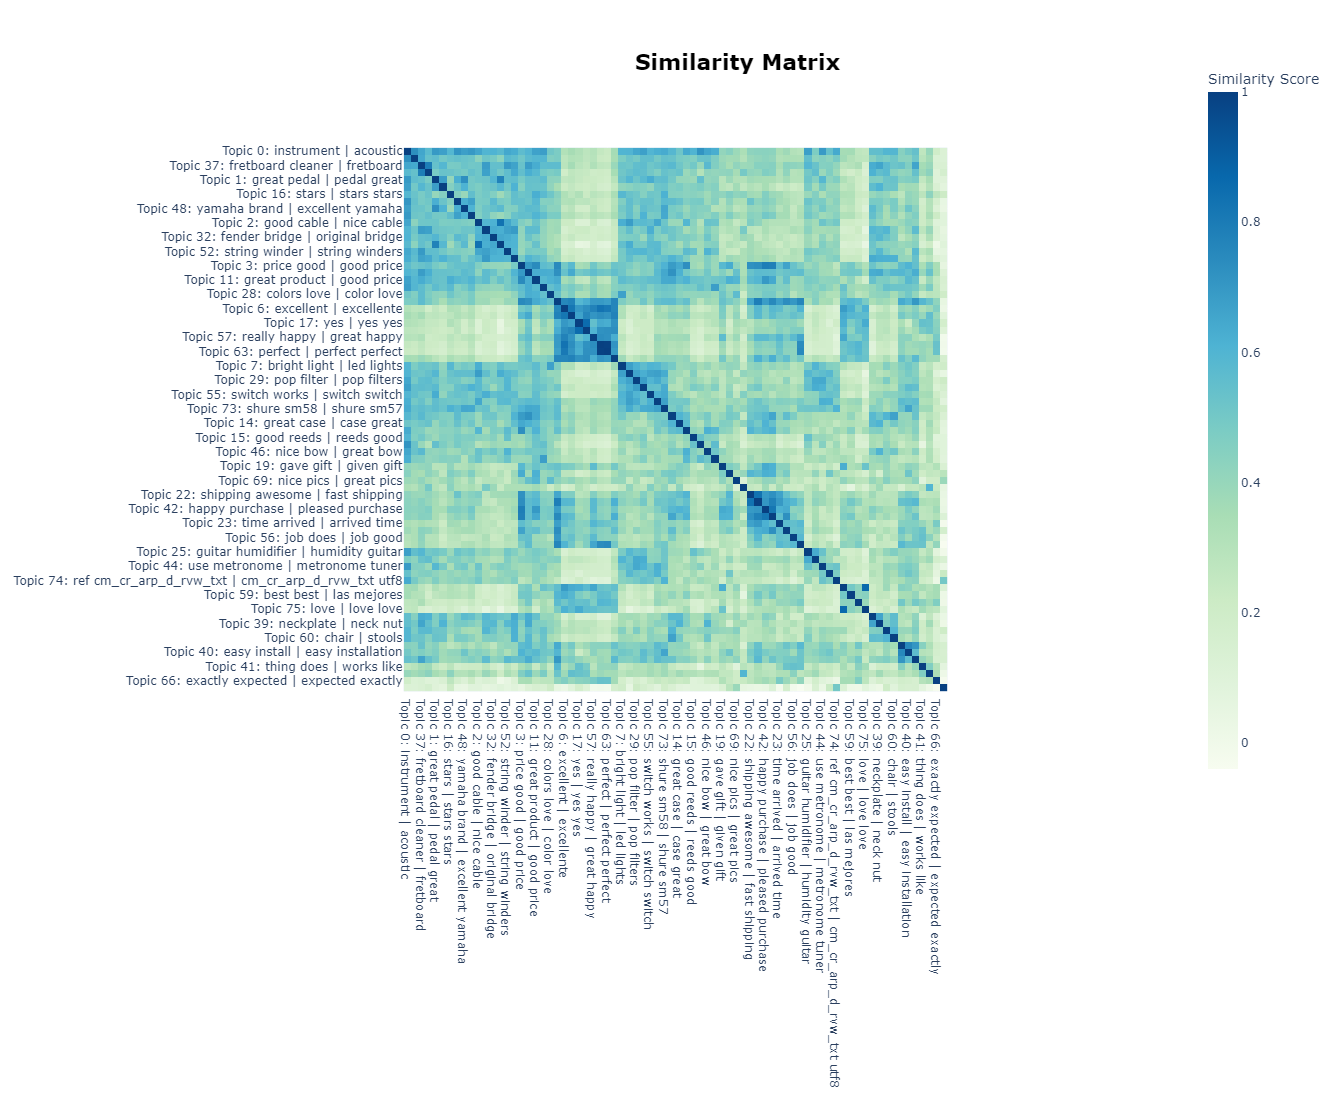

In [40]:
topic_model.visualize_heatmap(custom_labels=True, n_clusters=20, width=1100, height=1100)

In [41]:
fig2 = topic_model.visualize_heatmap(custom_labels=True, n_clusters=20, width=1100, height=1100)
fig2.write_html(r'C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Saved Models\BERTopic\heatmap.html')

The pairs of topics with high similarity score is listed below.

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(),
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index':
            continue
        tmp.append(
            {
                'topic1': t1,
                'topic2': t2,
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) &
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

topic1  \
4915  62_perfect perfect_perfect_thanks wonderful_pe...   
2155                   26_love_like love_love love_cool   
1422                             17_yes_meh_aok_yes yes   
282                   2_cable_cables_quality_connectors   
1796      22_shipping_fast shipping_fast_shipping great   
4858  62_perfect perfect_perfect_thanks wonderful_pe...   
3373               42_purchase_buy_happy purchase_happy   
854               10_good good_good nice_nice good_good   
4935                       63_perfect perfect_perfect__   
2980                      37_fretboard_fret_cloth_frets   
351                 3_price_great price_good price_good   
1931             24_delivery_service_fast delivery_fast   
370                 3_price_great price_good price_good   
1987             24_delivery_service_fast delivery_fast   
205                          1_pedal_pedals_board_delay   
853               10_good good_good nice_nice good_good   
916               10_good good_good nice_nice good_good   
4473         57_happy_satisfied_pleased_satisfied happy   
531           5_works great_works_product_great product   
5320  68_thanks thanks_thanks_excellent product_than...   

                                                 topic2  distance  
4915                       63_perfect perfect_perfect__  0.993809  
2155         75_love love_love_great strings_love great  0.861273  
1422                        35_ok ok_ok_ok cool_cool ok  0.854797  
282                   50_cables_patch_board_pedal board  0.835582  
1796             24_delivery_service_fast delivery_fast  0.832122  
4858  6_great great_excellent great_great excellent_...  0.829218  
3373        61_seller_seller great_great seller_product  0.817105  
854   6_great great_excellent great_great excellent_...  0.817062  
4935  6_great great_excellent great_great excellent_...  0.808394  
2980                53_plastic_cheap_cheap plastic_foam  0.791602  
351                42_purchase_buy_happy purchase_happy  0.791545  
1931          5_works great_works_product_great product  0.786850  
370         61_seller_seller great_great seller_product  0.781660  
1987        61_seller_seller great_great seller_product  0.780615  
205                   50_cables_patch_board_pedal board  0.777248  
853           5_works great_works_product_great product  0.777195  
916   68_thanks thanks_thanks_excellent product_than...  0.774986  
4473  6_great great_excellent great_great excellent_...  0.774554  
531   68_thanks thanks_thanks_excellent product_than...  0.763848  
5320  6_great great_excellent great_great excellent_...  0.762680

The decision regarding which topics to merge is made by a combination of visual analysis of the hierarchy tree and an understanding of the semantic content represented by each topic. The goal is to reduce redundancy within the topic model and creating a set of topics that are both distinct and comprehensive. Based on the insights from the hierarchy tree and the similarity scores, merging topics 62 and 63 would enhance the model's clarity and coherence. This resulted in a reduction of the total number of topics to 76, including the outlier category denoted as '-1'

In [43]:
topics_to_merge = [62, 63]
topic_model.merge_topics(docs, topics_to_merge)

In [44]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  83475                       -1_strings_guitar_great_good   
1       0  55221                           0_guitar_sound_great_mic   
2       1   8625                         1_pedal_pedals_board_delay   
3       2   8146                  2_cable_cables_quality_connectors   
4       3   3194                3_price_great price_good price_good   
..    ...    ...                                                ...   
71     70    174                   70_images_video_class_ssl images   
72     71    173  71_perfectly_works perfectly_perfectly works_p...   
73     72    161                              72_sm58_shure_sm57_58   
74     73    158  73_link_nbsp_cm_cr_arp_d_rvw_txt utf8_ref cm_c...   
75     74    153         74_love love_love_great strings_love great   

                                       Representation  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, great, mic, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
71  [images, video, class, ssl images, images na, ...   
72  [perfectly, works perfectly, perfectly works, ...   
73  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
74  [link, nbsp, cm_cr_arp_d_rvw_txt utf8, ref cm_...   
75  [love love, love, great strings, love great, s...   

                                              KeyBERT  \
0   [great, excellent, perfect, works great, good,...   
1   [instrument, acoustic, fender, guitars, amp, b...   
2   [great pedal, pedal great, pedals, pedalboard,...   
3   [good cable, nice cable, cable good, great cab...   
4   [price good, good price, price nice, nice pric...   
..                                                ...   
71  [id video, com images, images amazon, type hid...   
72  [works perfectly, perfectly works, worked perf...   
73  [shure sm58, shure sm57, shure sm7b, sm58 work...   
74  [ref cm_cr_arp_d_rvw_txt, cm_cr_arp_d_rvw_txt ...   
75  [love, love love, great love, love great, love...   

                                                  MMR  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, great, mic, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
71  [images, video, class, ssl images, images na, ...   
72  [perfectly, works perfectly, perfectly works, ...   
73  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
74  [link, nbsp, cm_cr_arp_d_rvw_txt utf8, ref cm_...   
75  [love love, love, great strings, love great, s...   

                                                  POS  \
0   [strings, guitar, great, good, sound, use, pro...   
1   [guitar, sound, great, mic, good, strings, str...   
2   [pedal, pedals, board, delay, power, distortio...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
71  [images, video, div, spacing, block, mini vide...   
72  [works, perfect, bad cut, past year, past, son...   
73  [shure, sm7b, perfect, great, price, used shur...   
74  [link, data, normal, guitar, stage, electric, ...   
75  [love, strings, great, spot, great pair, set, ...   

                                  Representative_Docs  
0        [GREAT, Great., These are my go to strings.]  
1   [I am really enjoying this guitar! Feels solid...  
2   [COMPARISONS: I have compared, side by side, t...  
3   [Good quality cable., Good quality cable., Ver...  
4   [Works well for great price. Bill, Very well-m...  
..                                                ...  
71  [<div id="video

## **Outlier Reduction**
Managing outliers is another important step in refining BERTopic model. Outliers refer to the reviews that do not quite fit into the model's defined topics. In this case, a significant portion of the reviews – 83,475 out of 198,940 reviews, equating to 41.96% – was classified as outliers. This presents a challenge because simply excluding these outliers could result in losing valuable insights from a large segment of the data. To mitigate this issue, the `reduce_outliers` function is used to reassess and reassign these outlier documents to existing topics and the `update_topics` function is ultilized to update the topic representation. The result is a remarkable decrease in outliers to only 413.

In [45]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(docs, topics)

100%|██████████| 84/84 [00:58<00:00,  1.43it/s]


In [46]:
topic_model.update_topics(docs, topics=new_topics)

2024-02-17 07:45:04,177 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [47]:
topic_model.get_topic_info()

Topic  Count                                     Name  \
0      -1    413                -1_aaaaaaa_none_made_must   
1       0  71469                          0_the_and_to_it   
2       1   9726                   1_pedal_pedals_it_this   
3       2   8709               2_cable_cables_quality_and   
4       3   7611               3_price_good_quality_great   
..    ...    ...                                      ...   
72     71   1046          71_images_video_class_perfectly   
73     72    355            72_shure_perfectly_sm58_works   
74     73    444  73_link_nbsp_linked_cm_cr_arp_d_rvw_txt   
75     74    211    74_link_nbsp_cm_cr_arp_d_rvw_txt_href   
76     75    153                 75_love_it_strings_great   

                                           CustomName  \
0                         Topic -1: great | excellent   
1                      Topic 0: instrument | acoustic   
2                  Topic 1: great pedal | pedal great   
3                    Topic 2: good cable | nice cable   
4                    Topic 3: price good | good price   
..                                                ...   
72                    Topic 71: id video | com images   
73        Topic 72: works perfectly | perfectly works   
74                  Topic 73: shure sm58 | shure sm57   
75  Topic 74: ref cm_cr_arp_d_rvw_txt | cm_cr_arp_...   
76                         Topic 75: love | love love   

                                       Representation  \
0   [aaaaaaa, none, made, must, excellet, well, ge...   
1       [the, and, to, it, for, of, is, my, this, on]   
2   [pedal, pedals, it, this, the, is, you, of, an...   
3   [cable, cables, quality, and, the, to, connect...   
4   [price, good, quality, great, for, money, chea...   
..                                                ...   
72  [images, video, class, perfectly, na, div, url...   
73  [shure, perfectly, sm58, works, worked, 58, pe...   
74  [link, nbsp, linked, cm_cr_arp_d_rvw_txt, href...   
75  [link, nbsp, cm_cr_arp_d_rvw_txt, href, linked...   
76  [love, it, strings, great, crip, spot, raggy, ...   

                                              KeyBERT  \
0   [great, excellent, perfect, works great, good,...   
1   [instrument, acoustic, fender, guitars, amp, b...   
2   [great pedal, pedal great, pedals, pedalboard,...   
3   [good cable, nice cable, cable good, great cab...   
4   [price good, good price, price nice, nice pric...   
..                                                ...   
72  [works perfectly, perfectly works, worked perf...   
73  [shure sm58, shure sm57, shure sm7b, sm58 work...   
74  [ref cm_cr_arp_d_rvw_txt, cm_cr_arp_d_rvw_txt ...   
75  [love, love love, great love, love great, love...   
76                                                NaN   

                                                  MMR  \
0   [strings, guitar, great, good, sound, use, jus...   
1   [guitar, sound, great, mic, like, good, string...   
2   [pedal, pedals, board, delay, pedal board, pow...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [perfectly, works perfectly, perfectly works, ...   
73  [sm58, shure, sm57, 58, sm, sm 58, shure sm58,...   
74  [link, nbsp, cm_cr_arp_d_rvw_txt utf8, ref cm_...   
75  [love love, love, great strings, love great, s...   
76                                                NaN   

                                                  POS  \
0   [strings, guitar, great, good, sound, use, pro...   
1   [guitar, sound, great, mic, good, strings, str...   
2   [pedal, pedals, board, delay, power, distortio...   
3   [cable, cables, quality, connectors, cord, xlr...   
4   [price, great price, good price, good, money, ...   
..                                                ...   
72  [works, perfect, bad cut, past year, past, son...   
73  [shure, sm7b, perfect, great, price, used shur...   
74  [link, data, n

## **Coherence Score**

In [48]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Extract all the topics with their respective words
topic_words = topic_model.get_topic_info()

# Prepare inputs for CoherenceModel
texts = [doc.split() for doc in docs]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Extract topic words for coherence calculation
topic_terms = [[word for word, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

# Map topic words to their token ids in the dictionary
topic_ids = [[dictionary.token2id[word] for word in topic if word in dictionary.token2id] for topic in topic_terms]

# Calculate coherence score using CoherenceModel from gensim
cm = CoherenceModel(topics=topic_ids, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
coherence_score = cm.get_coherence()

print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.4188503280262794


# V. Futher Analysis for Deeper Insights into Customer Feedback

Similar to LDA, BERTopic model can also provides insightful answers to the same key business questions include:
1. Which topics do customers talk about most and least in their reviews?
2. What topics are becoming more or less popular over time?
3. Which topics are linked to the highest and lowest customer ratings, and which products are connected to these topics?
4. For any given product, what topics are customers discussing the most?

Identifying which topics are most and least discussed by customers is straightforward with BERTopic outcome. The topic distribution is organized in descending order of popularity from top to bottom. With this, topic 0 (intrument, acoustic) is the most discussed topic in the reviews with 71,469 reviews and topic 75 (love, love love) is the least popular topic with only 153 reviews.

## Topics over time
Regarding the topic popularity over time, BERTopic has `topics_over_time` function that offers a clear visualization of how topics trend over periods. The interactive nature of this feature allows for specific topics to be focused on or filtered out, which can be particularly useful for users to track the rise or decline in popularity of specific topics.

As illustrated below, a pronounced increase in activity for all topics starts from 2013, reaches a peak in 2016, and then experiences a decline after mid-2016.

The prominent topic, Topic 0 (instrument, acoustic), shows a remarkable surge in interest from early 2012, peaking in 2015, before witnessing a sharp decline from 2017 onwards.

By excluding the dominant Topic 0, a more detailed picture reveals that other topics follows the similar pattern. They experience a rise at the beginning of 2012, with several topics experiencing a secondary surge towards the end of 2013, followed by a general decline starting in mid-2016. Certain topics stand out due to their more pronounced popularity, such as
- Topic 1 (great pedal, pedal great)
- Topic 2 (good cable, nice cable)
- Topic 3 (price good, good price)
- Topic 5 (works great, worked great)
- Topic 6 (excellent, excellente)
- Topic 8 (great, great great)
- Topic 11 (great product, good price)

The analysis indicates that customers have shown significant interest in certain product features, such as the quality of pedals and cables or the functionality of stands. With this knowledge, it would be advantageous for businesses to investigate the review content from these peak periods to identify the underlying factors contributing to these shifts in topic popularity.

20it [00:28,  1.43s/it]


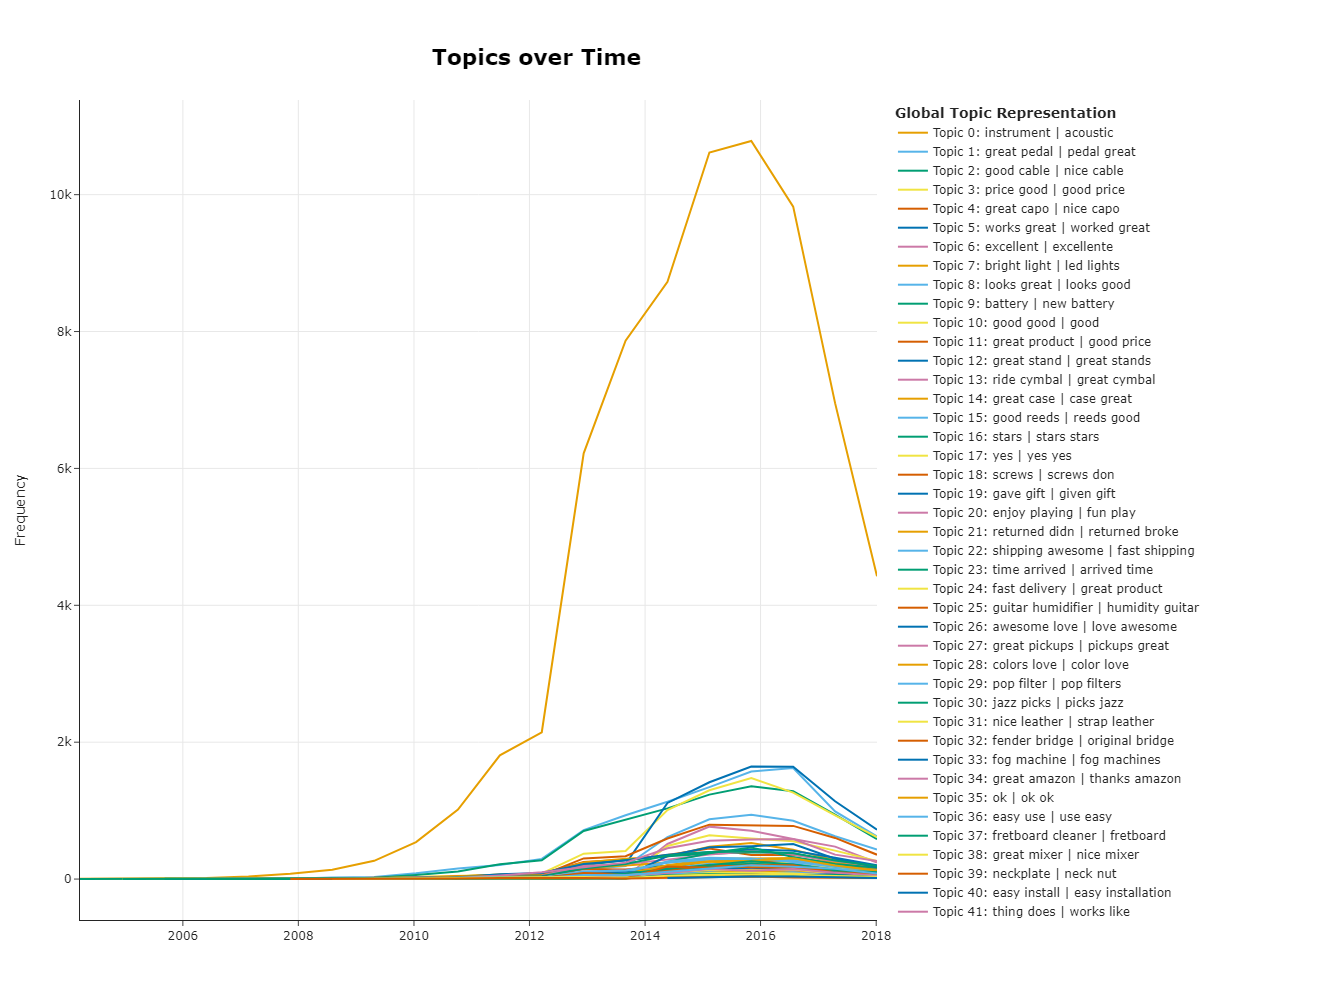

In [49]:
timestamps = df['reviewDate'].to_list()

topics_over_time = topic_model.topics_over_time(docs, timestamps=timestamps, datetime_format='%d/%m/%Y', nr_bins=20)

topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True, width=1800, height=1000)

In [50]:
fig3 = topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True, width=1800, height=1000)
fig3.write_html(r'C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Saved Models\BERTopic\topic_over_time.html')

## Topic by Ratings
By linking topics to customer ratings, BERTopic helps identify which subjects are correlated with higher or lower satisfaction levels, as well as the specific products related to these topics. This analysis can pinpoint areas of strength and opportunities for improvement.

In [51]:
df_docs = topic_model.get_document_info(docs)
df_docs

Document  Topic  \
0                                 It's good for beginners     52   
1       I recommend this starter Ukulele kit.  I has e...      0   
2       G'daughter received this for Christmas present...     19   
3       According to my order history, I bought this t...      0   
4       Please pay attention better than I did to the ...      0   
...                                                   ...    ...   
198935                                 It's pretty great.      6   
198936  Good inexpensive wiring harness. It will do th...      2   
198937           Easily installed and worked as expected.     40   
198938  The description stated they were full size pot...     21   
198939  They are dime size not "full size" pots but it...      3   

                                       Name  \
0               52_winder_cutter_puller_bad   
1                           0_the_and_to_it   
2                      19_gift_loves_son_he   
3                           0_the_and_to_it   
4                           0_the_and_to_it   
...                                     ...   
198935  6_excellent_great_awesome_excelente   
198936           2_cable_cables_quality_and   
198937              40_neck_nut_the_install   
198938     21_broke_returned_working_return   
198939           3_price_good_quality_great   

                                        CustomName  \
0         Topic 52: string winder | string winders   
1                   Topic 0: instrument | acoustic   
2                 Topic 19: gave gift | given gift   
3                   Topic 0: instrument | acoustic   
4                   Topic 0: instrument | acoustic   
...                                            ...   
198935             Topic 6: excellent | excellente   
198936            Topic 2: good cable | nice cable   
198937  Topic 40: easy install | easy installation   
198938    Topic 21: returned didn | returned broke   
198939            Topic 3: price good | good price   

                                           Representation  \
0       [winder, cutter, puller, bad, string, good, to...   
1           [the, and, to, it, for, of, is, my, this, on]   
2       [gift, loves, son, he, christmas, loved, she, ...   
3           [the, and, to, it, for, of, is, my, this, on]   
4           [the, and, to, it, for, of, is, my, this, on]   
...                                                   ...   
198935  [excellent, great, awesome, excelente, excelen...   
198936  [cable, cables, quality, and, the, to, connect...   
198937  [neck, nut, the, install, guitar, to, it, and,...   
198938  [broke, returned, working, return, didn, work,...   
198939  [price, good, quality, great, for, money, chea...   

                                                  KeyBERT  \
0       [good bad, good don, bad, bad quality, came ba...   
1       [instrument, acoustic, fender, guitars, amp, b...   
2       [gave gift, given gift, gift gift, gift, gift ...   
3       [instrument, acoustic, fender, guitars, amp, b...   
4       [instrument, acoustic, fender, guitars, amp, b...   
...                                                   ...   
198935  [excellent, excellente, excellent excellent, e...   
198936  [good cable, nice cable, cable good, great cab...   
198937  [neckplate, quality neck, nice neck, neck nice...   
198938  [returned didn, returned broke, didn work, ret...   
198939  [price good, good price, price nice, nice pric...   

                                                      MMR  \
0       [good, works, bad, flimsy, ok, best, expected,...   
1       [guitar, sound, great, mic, like, good, string...   
2       [gift, loves, son, christmas, loved, daughter,...   
3       [guitar, sound, great, mic, like, good, string...   
4       [guitar, sound, great, mic, like, good, string...   
...                                                   ...   
198935  [great great, excellent great, great excellent...   
198936  [cable, cables, quality, connectors, cord, xlr...   
198

In [52]:
# Define the list of columns to drop
columns_to_drop = ['Representation', 'KeyBERT', 'MMR', 'POS']

# Drop the specified columns from the DataFrame
df_docs.drop(columns=columns_to_drop, inplace=True)
df_docs

Document  Topic  \
0                                 It's good for beginners     52   
1       I recommend this starter Ukulele kit.  I has e...      0   
2       G'daughter received this for Christmas present...     19   
3       According to my order history, I bought this t...      0   
4       Please pay attention better than I did to the ...      0   
...                                                   ...    ...   
198935                                 It's pretty great.      6   
198936  Good inexpensive wiring harness. It will do th...      2   
198937           Easily installed and worked as expected.     40   
198938  The description stated they were full size pot...     21   
198939  They are dime size not "full size" pots but it...      3   

                                       Name  \
0               52_winder_cutter_puller_bad   
1                           0_the_and_to_it   
2                      19_gift_loves_son_he   
3                           0_the_and_to_it   
4                           0_the_and_to_it   
...                                     ...   
198935  6_excellent_great_awesome_excelente   
198936           2_cable_cables_quality_and   
198937              40_neck_nut_the_install   
198938     21_broke_returned_working_return   
198939           3_price_good_quality_great   

                                        CustomName  \
0         Topic 52: string winder | string winders   
1                   Topic 0: instrument | acoustic   
2                 Topic 19: gave gift | given gift   
3                   Topic 0: instrument | acoustic   
4                   Topic 0: instrument | acoustic   
...                                            ...   
198935             Topic 6: excellent | excellente   
198936            Topic 2: good cable | nice cable   
198937  Topic 40: easy install | easy installation   
198938    Topic 21: returned didn | returned broke   
198939            Topic 3: price good | good price   

                                      Representative_Docs  \
0       [good but not for me, Not good., not good enough]   
1       [I am really enjoying this guitar! Feels solid...   
2         [It is a gift., This is a gift, It was a gift.]   
3       [I am really enjoying this guitar! Feels solid...   
4       [I am really enjoying this guitar! Feels solid...   
...                                                   ...   
198935                  [Excellent, excellent, excellent]   
198936  [Good quality cable., Good quality cable., Ver...   
198937  [This is a VERY good neck for the money, but i...   
198938  [Didn't work so I returned it., didn't work wi...   
198939  [Works well for great price. Bill, Very well-m...   

                                              Top_n_words  Probability  \
0       winder - cutter - puller - bad - string - good...     0.000000   
1       the - and - to - it - for - of - is - my - thi...     0.904080   
2       gift - loves - son - he - christmas - loved - ...     0.692491   
3       the - and - to - it - for - of - is - my - thi...     0.000000   
4       the - and - to - it - for - of - is - my - thi...     0.000000   
...                                                   ...          ...   
198935  excellent - great - awesome - excelente - exce...     0.522357   
198936  cable - cables - quality - and - the - to - co...     1.000000   
198937  neck - nut - the - install - guitar - to - it ...     0.932652   
198938  broke - returned - working - return - didn - w...     0.000000   
198939  price - good - quality - great - for - money -...     0.000000   

        Representative_document  
0                         False  
1                         False  
2                         False  
3                         False  
4                         False  
...                         ...  
198935                    False  
198936                    False  
198937                    False  
198938                    False  
198939                

In [53]:
df = pd.merge(df, df_docs, left_index=True, right_index=True)
df

overall  verified   reviewTime      reviewerID        asin  \
0           5.0      True  10 30, 2016  A3FO5AKVTFRCRJ  0739079891   
1           5.0      True  06 30, 2016  A3UCGC1DHFMBCE  0739079891   
2           5.0      True   05 9, 2016  A2S9SLRYLPGYZB  0739079891   
3           4.0      True  04 10, 2016  A15RTJWPG8OKOE  0739079891   
4           1.0      True   02 6, 2016  A12ET1WO3OAVU7  0739079891   
...         ...       ...          ...             ...         ...   
198935      5.0      True  03 29, 2018  A2GLR2Q3M1PC7P  B01HIDOPP2   
198936      5.0      True  11 18, 2017  A3S1LSTRW57BP9  B01HIDOPP2   
198937      4.0      True   06 5, 2017  A2BNWRRADDBSVO  B01HIDOPP2   
198938      1.0      True  05 27, 2017  A1KRL5ZRON6DPT  B01HIDOPP2   
198939      5.0      True  03 24, 2017  A3QN3W0PJ1DXIT  B01HIDOPP2   

            reviewerName                                         reviewText  \
0              francisco                            It's good for beginners   
1         Eb Jack Murray  I recommend this starter Ukulele kit.  I has e...   
2           Clara LaMarr  G'daughter received this for Christmas present...   
3                Eagle80  According to my order history, I bought this t...   
4        Amazon Customer  Please pay attention better than I did to the ...   
...                  ...                                                ...   
198935         nic field                                 It's pretty great.   
198936             2gene  Good inexpensive wiring harness. It will do th...   
198937               Tim           Easily installed and worked as expected.   
198938  Jude the Obscure  The description stated they were full size pot...   
198939     Doug Clayburg  They are dime size not "full size" pots but it...   

                                                  summary  unixReviewTime  \
0                                              Five Stars      1477785600   
1                                              Five Stars      1467244800   
2                    Learning new songs to play regularly      1462752000   
3       A bargain-bin good-enough ukulele that's held ...      1460246400   
4                                   Poor Quality product.      1454716800   
...                                                   ...             ...   
198935                                         Five Stars      1522281600   
198936                                         Five Stars      1510963200   
198937                                         Four Stars      1496620800   
198938                                  Not as described.      1495843200   
198939                                        Works great      1490313600   

       vote  ... image reviewDate  \
0       NaN  ...   NaN 2016-10-30   
1       NaN  ...   NaN 2016-06-30   
2       NaN  ...   NaN 2016-05-09   
3       NaN  ...   NaN 2016-04-10   
4       NaN  ...   NaN 2016-02-06   
...     ...  ...   ...        ...   
198935  NaN  ...   NaN 2018-03-29   
198936  NaN  ...   NaN 2017-11-18   
198937  NaN  ...   NaN 2017-06-05   
198938  NaN  ...   NaN 2017-05-27   
198939  NaN  ...   NaN 2017-03-24   

                                                 Document Topic  \
0                                 It's good for beginners    52   
1       I recommend this starter Ukulele kit.  I has e...     0   
2       G'daughter received this for Christmas present...    19   
3       According to my order history, I bought this t...     0   
4       Please pay attention better than I did to the ...     0   
...                                                   ...   ...   
198935                                 It's pretty great.     6   
198936  Good inexpensive wiring harness. It will do th...     2   
198937           Easily installed and worked as expected.    40   
198938  The description stated they were full size pot...    21   
198939  They are dime size not "full size" pots but it...     3   

                                       Name

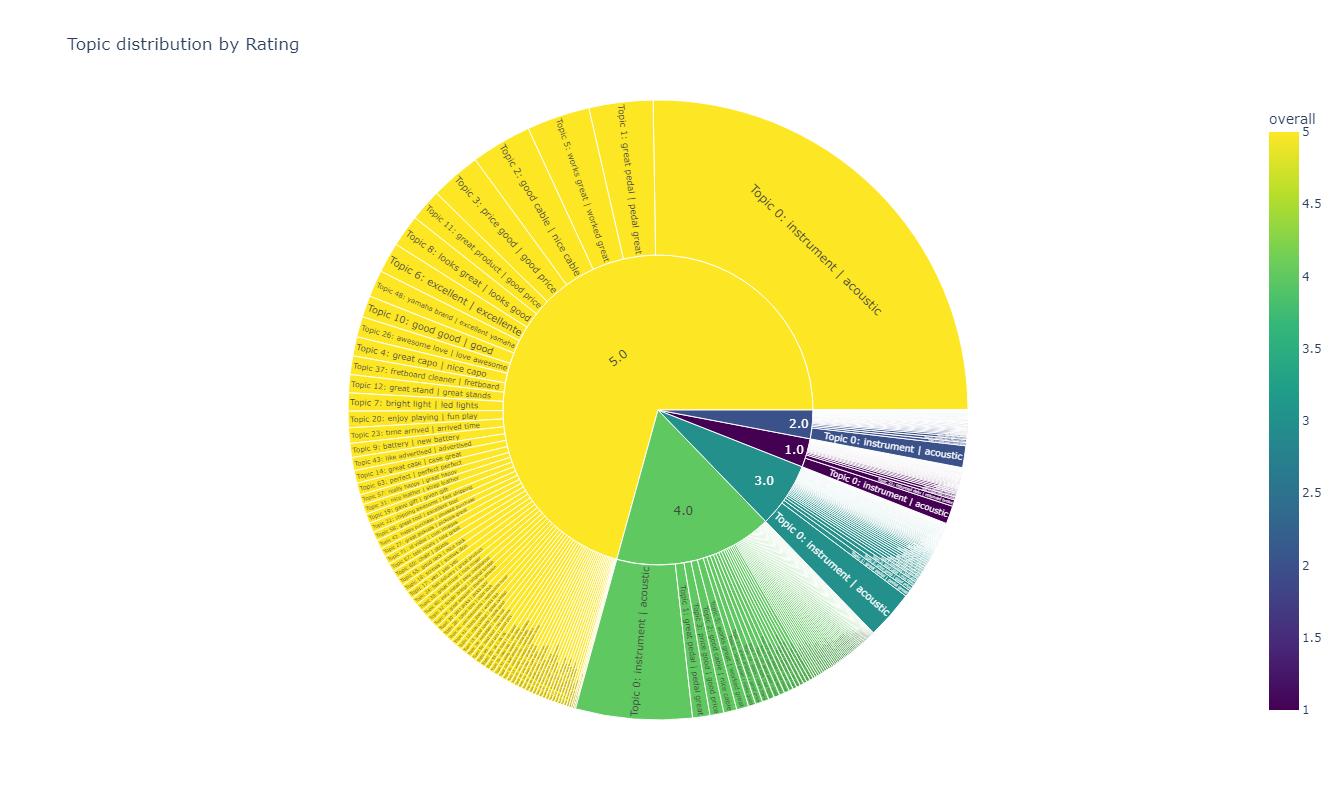

In [54]:
agg_data = df[["overall", "CustomName"]].groupby(["overall", "CustomName"]).size().reset_index(name="Count")
# define figure element
fig = px.sunburst(
    agg_data,
    values='Count',
    path=["overall", "CustomName"],
    title="Topic distribution by Rating",
    color="overall",
    height=800,
    #color_discrete_sequence=px.colors.qualitative.Prism,
    color_continuous_scale=px.colors.sequential.Viridis
)
# display the figure
fig.show()

From pie chart above, it is observed that Topic 0 (instrument, acoustic) make up a significant portion of the reviews across five different ratings. This suggests that the most frequent discussions within the dataset are about instruments, with a particular emphasis on acoustic.

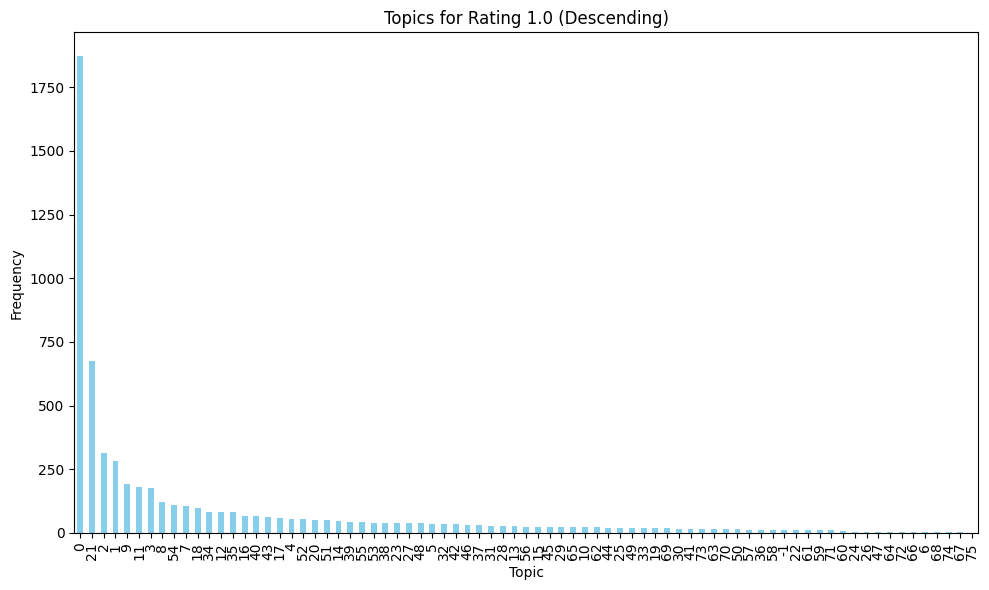

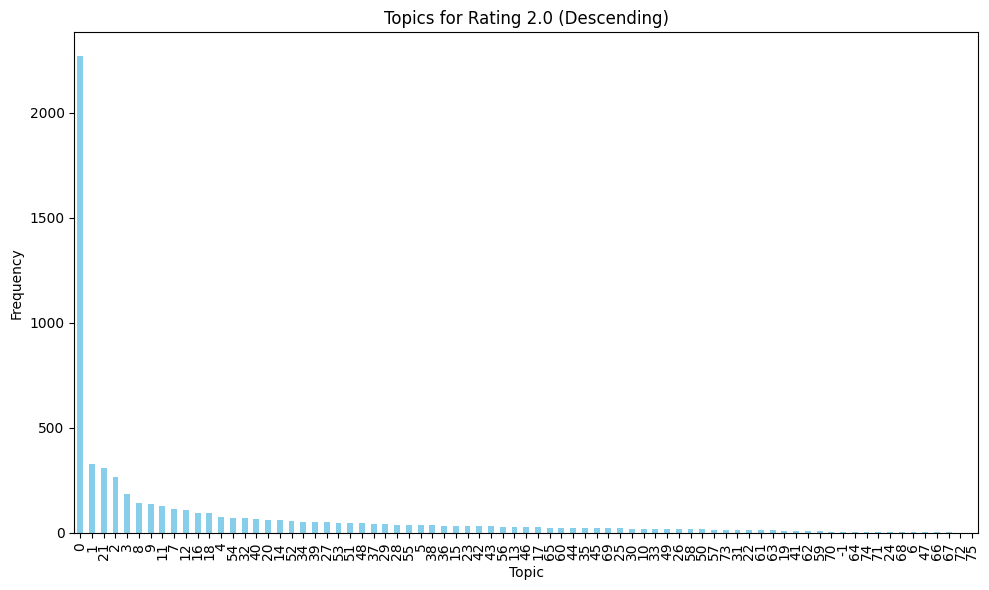

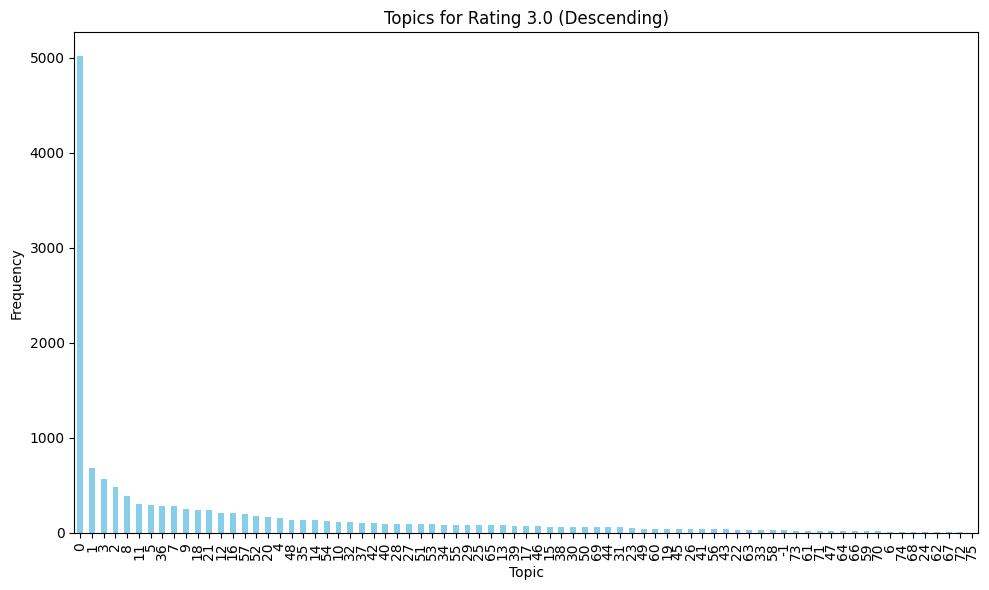

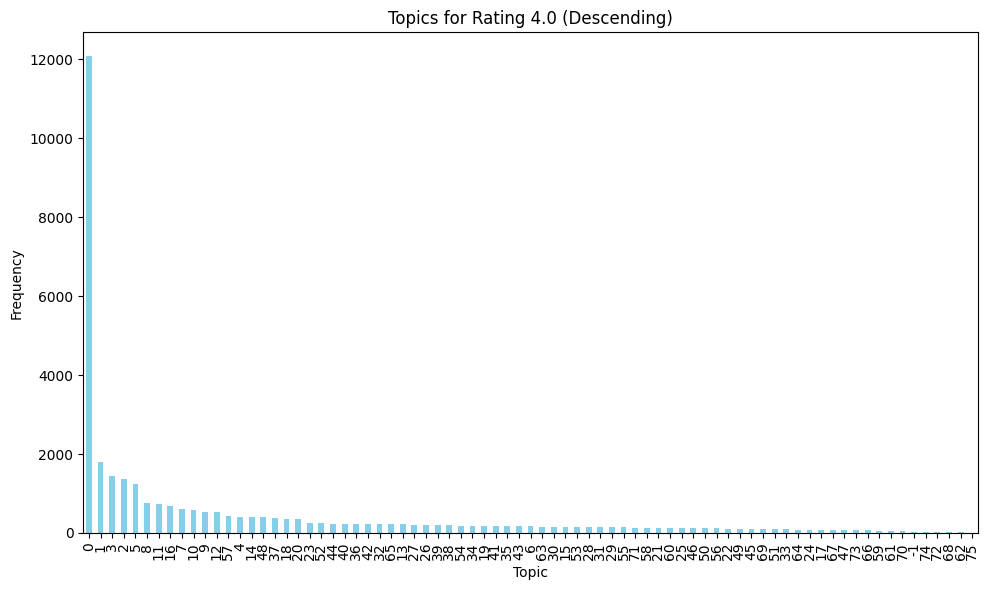

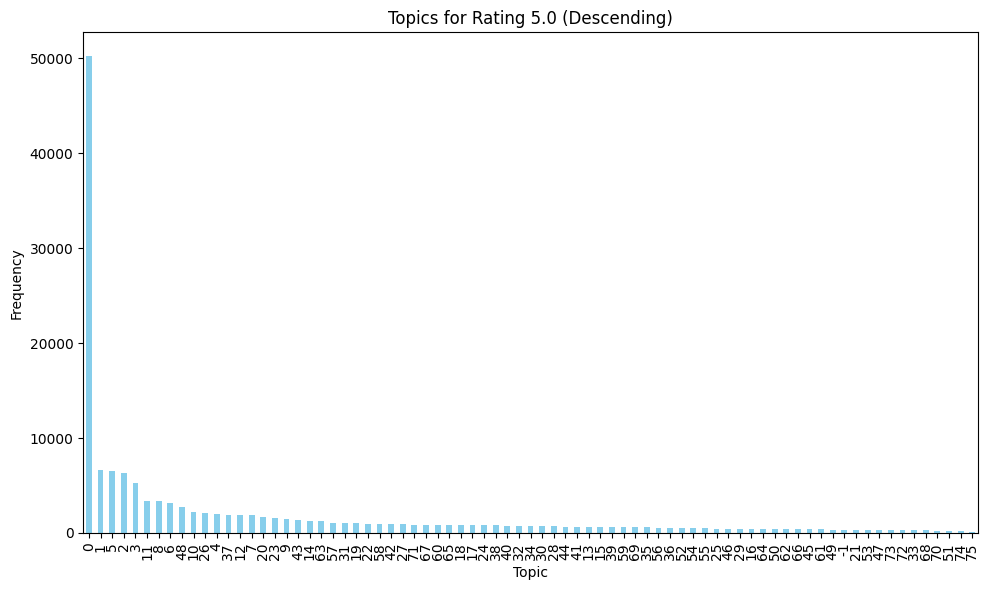

In [55]:
# Now, group by Rating and Topic to get the count
topic_counts = df.groupby(['overall', 'Topic']).size().unstack(fill_value=0)

# Calculate the sum of each topic across all ratings and sort by frequency in descending order
topic_counts_sum = topic_counts.sum(axis=0).sort_values(ascending=False)

# Reorder the columns in topic_counts based on the sorted topic_counts_sum
topic_counts = topic_counts[topic_counts_sum.index]

# Create a bar chart for each rating
for rating in sorted(topic_counts.index):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    sorted_topics = topic_counts.loc[rating].sort_values(ascending=False)
    sorted_topics.plot(kind='bar', color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.title(f'Topics for Rating {rating} (Descending)')
    plt.xticks(range(len(sorted_topics)), sorted_topics.index, rotation=90)
    plt.tight_layout()  # Ensure the labels fit within the figure
    plt.show()

The bar charts represent the distribution of topics across different rating levels, specifically for ratings 1.0 through 5.0. Each bar chart shows the frequency of topics associated with each rating, sorted in descending order.

One of the most frequent topics assosicated with low rating 1.0 and 2.0 is Topic 21 (returned didn, returned broke). This suggests that functionality issues or product defects are a common thread in negative customer experiences. This shows that bad product quality has a high impact on negative customer satisfaction, which is an suggests a needed improvement in product quality.

Conversely, in the higher rating categories of 4.0 and 5.0, one of the most frequent topics is Topic 3 (price good, good price) and 
Topic 5 (works great, worked great). This indicates that perceptions of value for money and good product quality are strong contributing factors to positive customer reviews..

Expanding on this analysis, businesses can delve deeper into the content of these topics for more insights. For example,the  content of reviews associated with Topic 12 (returned didn,returned brokek) can reveal factors influencing the negative sentiment, which could lead to product improvements that reduce returns and increase customer satisfaction. Meanwhile, identifingy positive attributes that driveTopic 3 (price good, good price) and Topic 5 (works great, worked great)) could further enhance customer satisfaction with product quality and value.

Furthermore, tracking these topics over time could reveal trends in customer priorities and emerging issues. For instance, if the frequency of mentions for "returned didn't, didn't work" begins to rise, it could signal an emerging issue in product quality that needs immediate attention


## Topic distribution for a specific product

In [56]:
def plot_topic_distribution(df, product_id, color):
    """
    Plots the distribution of topics for a specific product.

    Parameters:
    - df: DataFrame containing the data.
    - product_id: The ASIN of the product to analyze.
    - color: Color of the bars in the graph.
    """
    # Filter the DataFrame for the specific product ID
    product_topics = df[df['asin'] == product_id]

    # Count the number of occurrences for each topic for the product
    topic_counts = product_topics['Topic'].value_counts().sort_values(ascending=False)

    # Map topic IDs to topic names
    topic_names = product_topics.drop_duplicates(subset=['Topic'])[['Topic', 'CustomName']].set_index('Topic')['CustomName']
    topic_counts.index = topic_counts.index.map(topic_names)

    # Plotting
    plt.figure(figsize=(10, 6))
    topic_counts.plot.bar(color=color)
    plt.title(f'Topic Distribution for Product {product_id}')
    plt.xlabel('Topic Name')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    #plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [57]:
# Filter the dataset for products with a 5-star rating and having Topic 3
five_star_products = df[(df['overall'] == 5.0) & (df['Topic'] == 3)]

# Count the number of 5-star ratings for each product
five_star_counts = five_star_products['asin'].value_counts()

# Get the top 5 products with the most 5-star ratings
top_5_products = five_star_counts.head(5)

# Print the index (product IDs) of the top 5 products
print("The index (product IDs) of the top 5 products are:")
print(top_5_products.index)

The index (product IDs) of the top 5 products are:
Index(['B0002E3CK4', 'B0002H03YY', 'B0002H05BA', 'B0006LOBA8', 'B0002H0A3S'], dtype='object', name='asin')


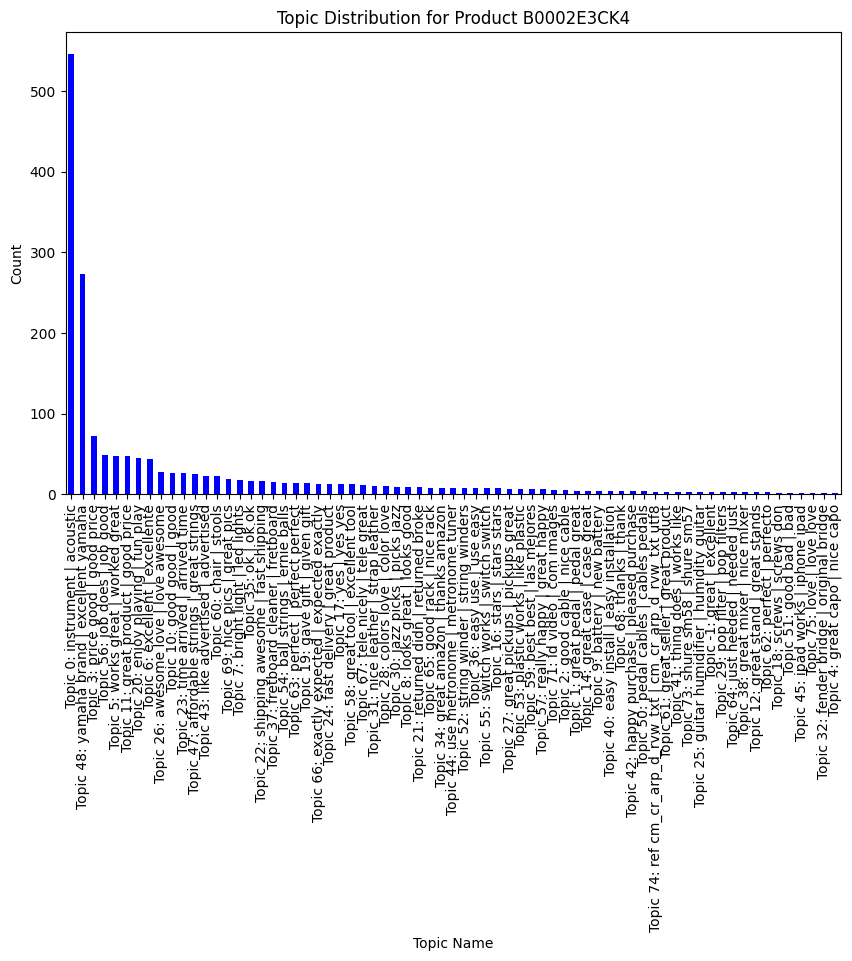

In [58]:
# plotting the distribution
plot_topic_distribution(df, 'B0002E3CK4', 'blue')

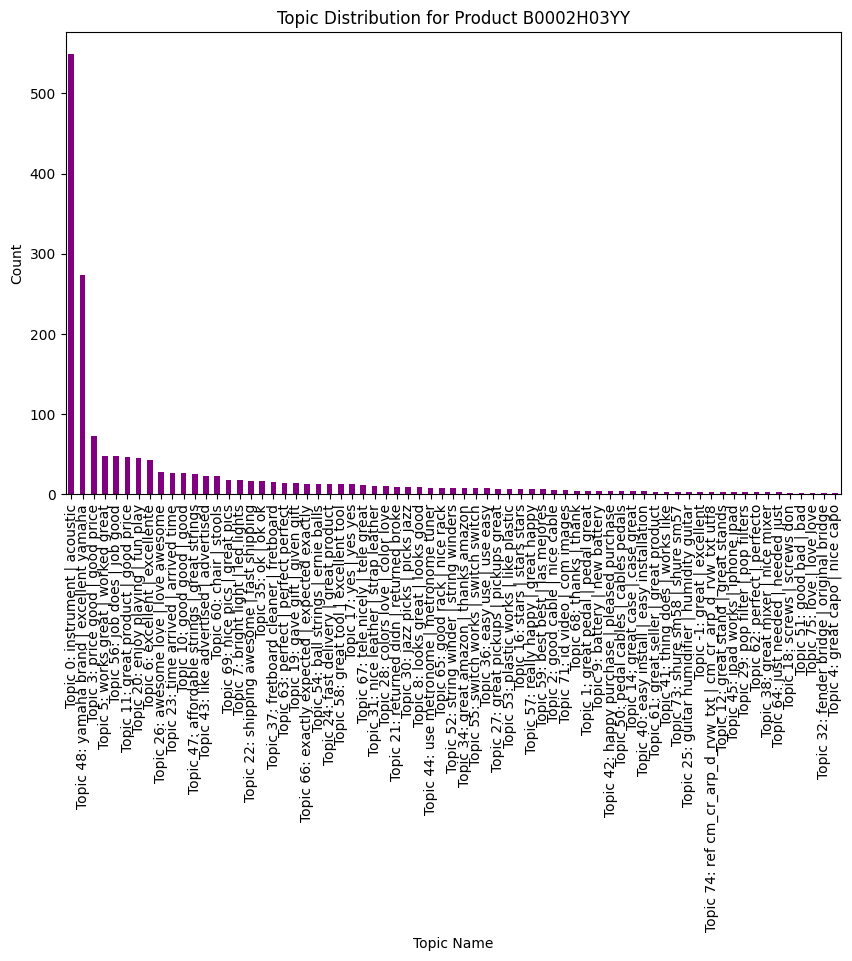

In [59]:
plot_topic_distribution(df, 'B0002H03YY', 'purple')

In [60]:
# Filter the dataset for products with a 1-star rating and having topic 21
one_star_products = df[(df['overall'] == 1.0) & (df['Topic'] == 21)]

# Count the number of 5-star ratings for each product
one_star_counts = one_star_products['asin'].value_counts()

# Get the top 5 products with the most 5-star ratings
top_5_products = one_star_counts.head(5)

# Print the index (product IDs) of the top 5 products
print("The index (product IDs) of the top 5 products are:")
print(top_5_products.index)

The index (product IDs) of the top 5 products are:
Index(['B00ACGMOA6', 'B0027V760M', 'B002UAF1PW', 'B0017H4EBG', 'B0002E1NNC'], dtype='object', name='asin')


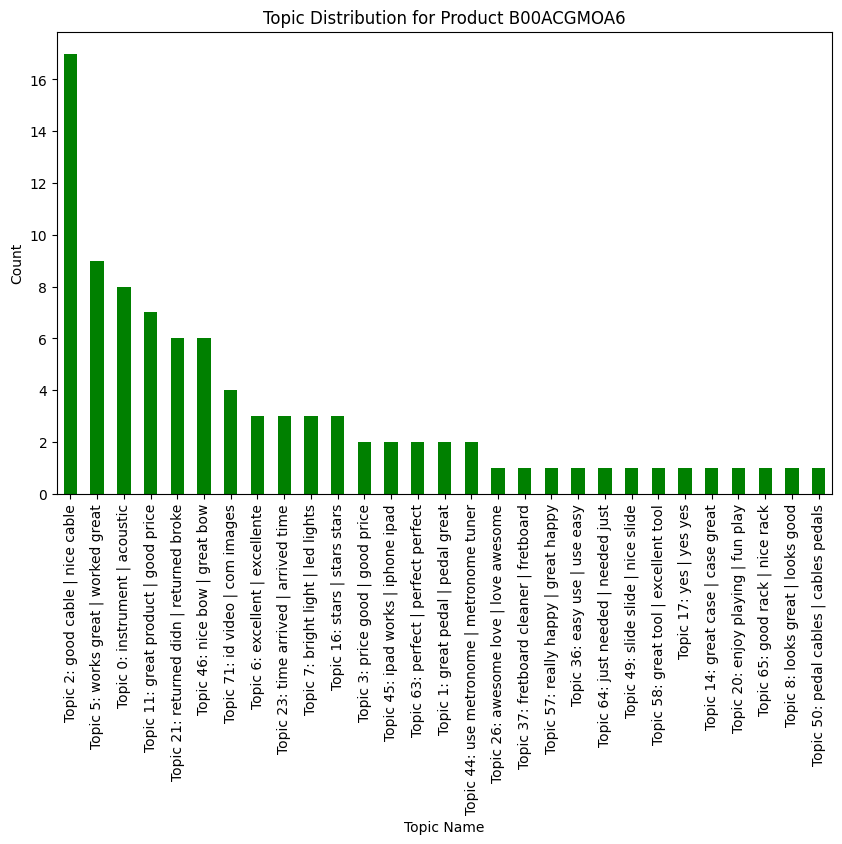

In [61]:
plot_topic_distribution(df, 'B00ACGMOA6', 'green')

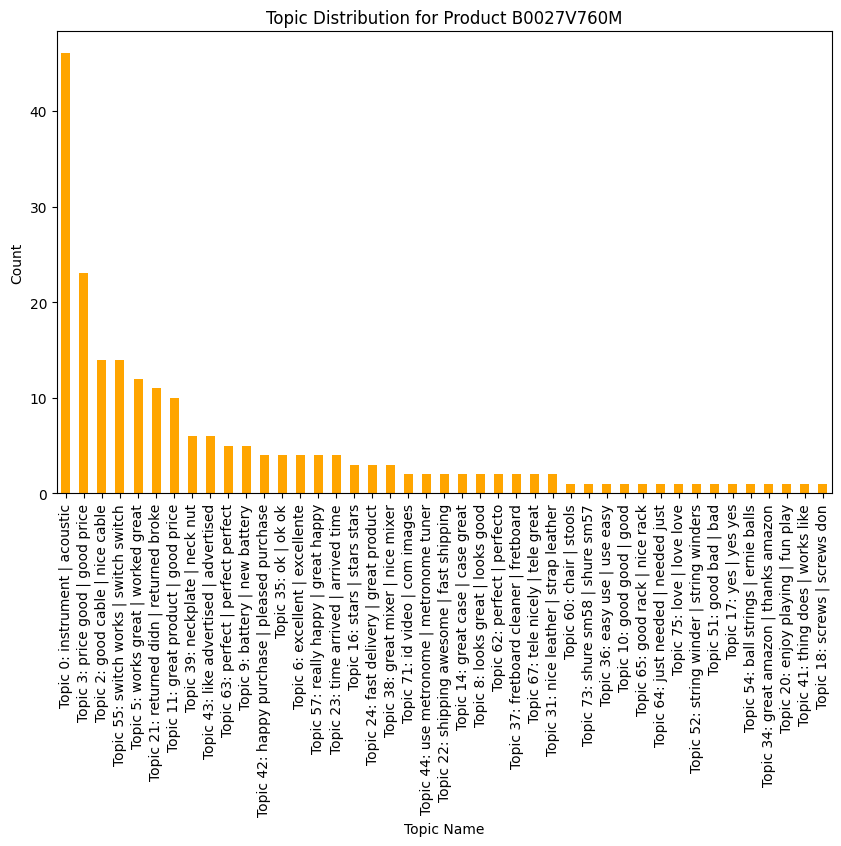

In [62]:
plot_topic_distribution(df, 'B0027V760M', 'orange')

Moreover, for any given product, it can easily identify the topics associated with that product.

For example, among the products with a 1.0 rating linked to Topic 21 (returned didn, returned broke) such as B0027V760M and B00ACGMOA6, there is a wider range of topics in the feedback.

For product B0027V760M, while returns and malfunctions are noted, the dominance of Topic 2 (good cable, nice cable), Topic 5 (works great, worked great), Topic 0 (instrument, acoustic), and Topic 11 (great product, good price) in the topic distribution suggest that a majority of customers express satisfaction with the product’s quality or usability.

Similarly, Product B00ACGMOA6 has mostly good evaluations for its cables, guitar accessories, functionality, and overall product quality, despite some reported faults.

These observations imply that issues leading to a product's return may represent a smaller fraction of the customer feedback since most reviews indicate a positive experience with the product. The topic distribution for each product not only reflects the customer's immediate response to product features but also serves as a diagnostic tool to pinpoint areas for product development and enhance customer experience.

## Topic distribution for a specific review

Unlike the final LDA model, where each review is a mixture of topics, BERTopic identifies only the most relevant topics for each review. This specificity is applicable to both long and short text reviews. This means that for any given review, BERTopic will pinpoint the topics that are actually mentioned or implied in the text, rather than providing a probability distribution across all topics.

For example, the review “G'daughter received this for Christmas present last year and plays if often.” has Topic 75 (son loves, loves son) and Topic 24 (gave gift, given gift) as shown below.


In [63]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(docs, window=8, stride=4)

100%|██████████| 199/199 [00:46<00:00,  4.26it/s]


In [64]:
review_id = 2
print(docs[review_id])

G'daughter received this for Christmas present last year and plays if often.


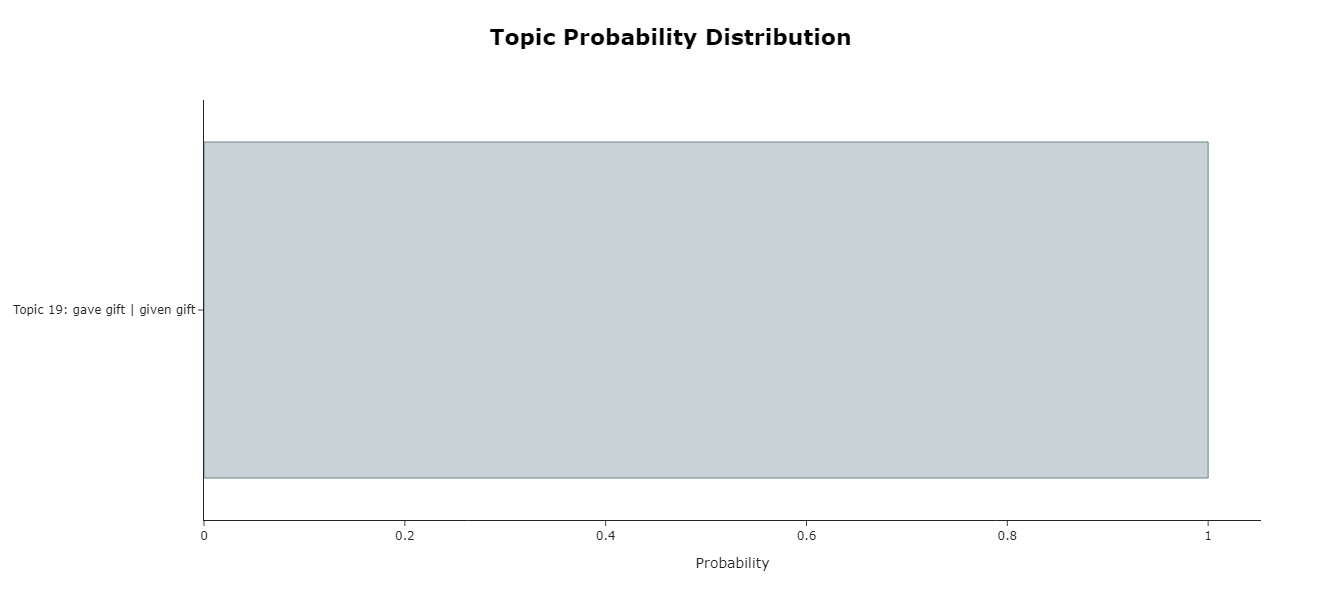

In [65]:
# Visualize the topic-document distribution for a single review
topic_model.visualize_distribution(topic_distr[review_id], custom_labels=True)

In [66]:
review_id = 3
print(docs[review_id])

According to my order history, I bought this this kit towards the end of 2012 as a Black Friday Week Lightning Deal. I'm writing this nearly four years later.

As with any stringed instrument, the strings really needed to stretch out before they would stay in tune. So, for the first several days, it was play a few minutes, tune, play a few minutes, tune. Then it was tuning daily. After a few weeks of this, the uke held a tune great. A tuner is not included in the package, which is the bulk of the minus star because a real beginner wouldn't have a way to tune the thing. (You need either a tuner or a reference note, say, on a piano or keyboard.) You can download a decent tuner app, though, for a buck or so. Do it, because you're going to need it a lot for the first couple of weeks.

The "Firebrand" ukulele is a laminated instrument of unknown wood. It's kind of dead-sounding. But then, soprano ukes generally sound a bit flattish to me - it's part of their distinctive character. The finis

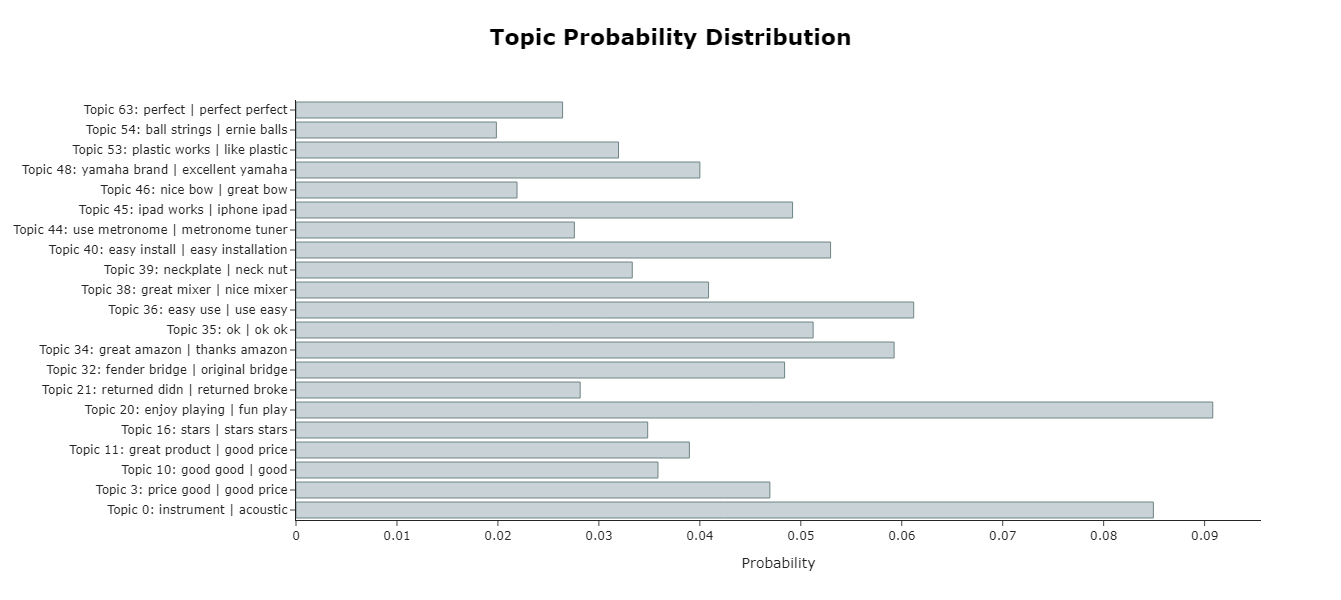

In [67]:
# Visualize the topic-document distribution for a single review
topic_model.visualize_distribution(topic_distr[review_id], custom_labels=True)

# VI. Save BERTopic model

In [69]:
# define a function to save the BERTopic model to a specific folder path
def save_model(topic_model, custom_model_name, embedding_model):
    # Specify the folder path where you want to save the model
    folder_path = r'C:\Users\QuynhDinhHaiPham\Desktop\2. Python Code\Saved Models\BERTopic'

    # Save the model to the specified folder with the custom name
    topic_model.save(os.path.join(folder_path, f"{custom_model_name}"), serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [70]:
# Call the function to save the model
save_model(topic_model=topic_model, custom_model_name="final_model_keybert", embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")